[link text](https://)# Synthesis mode classification for Heavy Ion Collisions for diffrent dataset size and K-Folding

**Authors:** [Haydar Mehryar](https://github.com/hmehryar) <br>
**Date created:** 2023/12/01<br>
**Last modified:** 2020/12/20<br>
**Description:** Implementation of Pointnet Deep Network for heavy ion colllisions classifiction

In [ ]:
import tensorflow as tf
# device_name = tf.test.gpu_device_name()
# if device_name != '/device:GPU:0':
#   raise SystemError('GPU device not found')
# print('Found GPU at: {}'.format(device_name))
print (tf.__version__)
print(len(tf.config.experimental.list_physical_devices('GPU'))>0)
from tensorflow import keras
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')
import sys
sys.path.insert(1,'/wsu/home/gy/gy40/gy4065/hm.jetscapeml.source')
sys.path.insert(1,'/content/drive/My Drive/Projects/110_JetscapeMl/hm.jetscapeml.source')
sys.path.insert(1,'/g/My Drive/Projects/110_JetscapeMl/hm.jetscapeml.source')
sys.path.insert(1,'G:\\My Drive\\Projects\\110_JetscapeMl\\hm.jetscapeml.source')

In [ ]:
# loading libraries
print('Loading/Installing Package => Begin\n\n')
import jet_ml_dataset_builder.jet_ml_dataset_builder_utilities as util
from jet_ml_dataset_builder.jet_ml_dataset_builder_utilities import set_directory_paths
from jet_ml_dataset_builder.jet_ml_dataset_builder_utilities import parse_parameters
from jet_ml_dataset_builder.jet_ml_dataset_builder_utilities import load_dataset
from jet_ml_dataset_builder.jet_ml_dataset_builder_utilities import install

import os
from time import time
import glob

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint,History,TensorBoard
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import json
%matplotlib inline

tf.random.set_seed(1234)
print('\nLoading/Installing Package => End\n\n')


In [ ]:
print('\n########################################################################')
print('Checking the running platforms\n')

# Call the function and retrieve the dataset_directory_path and simulation_directory_path
dataset_directory_path, simulation_directory_path = set_directory_paths()

# Access the dataset_directory_path and simulation_directory_path
print("Dataset Directory Path:", dataset_directory_path)
print("Simulation Directory Path:", simulation_directory_path)
print('########################################################################\n')

In [ ]:
tokenized_arguments, tokenized_values = parse_parameters()
# Call the function and retrieve the tokenized parameters
# Access the tokenized arguments and values
print("Tokenized Arguments:")
for argument in tokenized_arguments:
    print(argument)

print("\nTokenized Values:")
for argument, value in tokenized_values.items():
    print(f"{argument}: {value}")

y_class_label_items=['MMAT','MLBT']
alpha_s_items=[0.2 ,0.3 ,0.4]
q0_items=[1.5 ,2.0 ,2.5]

print("y_class_label_items:",y_class_label_items)
print("alpha_s_items:",alpha_s_items)
print("q0_items:",q0_items)

In [ ]:
print("Building required params for the loading the dataset file")

class_labels_str = '_'.join(y_class_label_items)
alpha_s_items_str='_'.join(map(str, alpha_s_items))
q0_items_str='_'.join(map(str, q0_items))
# total_size=9*1200000

In [ ]:
# loading dataset by size and getting just the first column
# Function to load datasets of different sizes
def get_dataset(size):
    dataset_file_name = f"jet_ml_benchmark_config_01_to_09_alpha_{alpha_s_items_str}_q0_{q0_items_str}_{class_labels_str}_size_{size}_shuffled.pkl"

    dataset_file_name=dataset_directory_path+dataset_file_name
    print("dataset_file_name:",dataset_file_name)

    dataset=load_dataset(dataset_file_name,has_test=False)
    (dataset_x, dataset_y) = dataset
    print('Extract the first column for binary classification')
    # dataset_y = dataset_y[:, 0]
    print("dataset.x:",type(dataset_x), dataset_x.size, dataset_x.shape)
    print("dataset.y:",type(dataset_y), dataset_y.size,dataset_y.shape)
    return dataset_x, dataset_y

Building and Compiling the Classifier model

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, History

def conv_bn(x, filters):
    x = layers.Conv1D(filters, kernel_size=1, padding="valid")(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)


def dense_bn(x, filters):
    x = layers.Dense(filters)(x)
    x = layers.BatchNormalization(momentum=0.0)(x)
    return layers.Activation("relu")(x)


class OrthogonalRegularizer(keras.regularizers.Regularizer):
    def __init__(self, num_features, l2reg=0.001):
        self.num_features = num_features
        self.l2reg = l2reg
        self.eye = tf.eye(num_features)

    def __call__(self, x):
        x = tf.reshape(x, (-1, self.num_features, self.num_features))
        xxt = tf.tensordot(x, x, axes=(2, 2))
        xxt = tf.reshape(xxt, (-1, self.num_features, self.num_features))
        return tf.reduce_sum(self.l2reg * tf.square(xxt - self.eye))

    def get_config(self):
        return {'num_features': self.num_features, 'l2reg': self.l2reg}

def tnet(inputs, num_features):

    # Initalise bias as the indentity matrix
    bias = keras.initializers.Constant(np.eye(num_features).flatten())
    reg = OrthogonalRegularizer(num_features)

    x = conv_bn(inputs, 32)
    x = conv_bn(x, 64)
    x = conv_bn(x, 512)
    x = layers.GlobalMaxPooling1D()(x)
    x = dense_bn(x, 256)
    x = dense_bn(x, 128)
    x = layers.Dense(
        num_features * num_features,
        kernel_initializer="zeros",
        bias_initializer=bias,
        activity_regularizer=reg,
    )(x)
    feat_T = layers.Reshape((num_features, num_features))(x)
    # Apply affine transformation to input features
    return layers.Dot(axes=(2, 1))([inputs, feat_T])

def build_pointnet_classifier_model(NUM_POINTS,NUM_CLASSES, model_name="pointnet"):
    inputs = keras.Input(shape=(NUM_POINTS, 3))
    x = tnet(inputs, 3)
    x = conv_bn(x, 32)
    x = conv_bn(x, 32)
    x = tnet(x, 32)
    x = conv_bn(x, 32)
    x = conv_bn(x, 64)
    x = conv_bn(x, 512)
    x = layers.GlobalMaxPooling1D()(x)
    x = dense_bn(x, 256)
    x = layers.Dropout(0.3)(x)
    x = dense_bn(x, 128)
    x = layers.Dropout(0.3)(x)

    if NUM_CLASSES <=2:
        outputs = layers.Dense(NUM_CLASSES, activation="sigmoid")(x)
    else:
        outputs = layers.Dense(NUM_CLASSES, activation="softmax")(x)
    

    model = keras.Model(inputs=inputs, outputs=outputs, name=model_name)
    return model

In [ ]:
# NUM_POINTS = 2048
NUM_POINTS = 1024
# NUM_CLASSES = 10

eloss_pointnet=build_pointnet_classifier_model(NUM_POINTS,NUM_CLASSES=2,model_name="ElossPointNet")
alpha_s_pointnet=build_pointnet_classifier_model(NUM_POINTS,NUM_CLASSES=3,model_name="AlphaSPointNet")
q_0_pointnet=build_pointnet_classifier_model(NUM_POINTS,NUM_CLASSES=4,model_name="Q0PointNet")
learning_rate=0.001

In [ ]:
def compile_pointnet_classifier_model_with_hyperparam(model,learning_rate,num_classes):
  if num_classes==None:
    raise Exception("Number of classses are not defined!")
  optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
  
  loss="binary_crossentropy"
  metrics=["accuracy"]
  
  if num_classes>2:
    loss="sparse_categorical_crossentropy"
    metrics=["sparse_categorical_accuracy"]
  model.compile(
      loss=loss,
      optimizer=optimizer,
      metrics=metrics,
  )
  model.summary()
  return model

In [ ]:
eloss_pointnet=compile_pointnet_classifier_model_with_hyperparam(eloss_pointnet,learning_rate,num_classes=2)
alpha_s_pointnet=compile_pointnet_classifier_model_with_hyperparam(alpha_s_pointnet,learning_rate,num_classes=3)
q_0_pointnet=compile_pointnet_classifier_model_with_hyperparam(q_0_pointnet,learning_rate,num_classes=4)


In [ ]:
tf.keras.utils.plot_model(eloss_pointnet, show_shapes=True)
tf.keras.utils.plot_model(alpha_s_pointnet, show_shapes=True)
tf.keras.utils.plot_model(q_0_pointnet, show_shapes=True)

In [ ]:
def split_dataset(dataset_x, dataset_x_points, dataset_y, test_size=0.2, random_state=None):
    """
    Split the dataset into training and testing sets.

    Parameters:
    - dataset_x: The input data (3D array).
    - dataset_x_points: The 3D coordinates corresponding to each entry.
    - dataset_y: The target values (2D array).
    - test_size: The proportion of the dataset to include in the test split.
    - random_state: Seed for random number generation.

    Returns:
    - x_train, x_test: The split input data for training and testing.
    - x_train_points, x_test_points: The split 3D coordinates for training and testing.
    - y_train, y_test: The split target values for training and testing.
    """
    # Flatten the input data to 2D
    flattened_dataset_x = dataset_x.reshape(dataset_x.shape[0], -1)

    # Split the dataset
    x_train, x_test, x_train_points, x_test_points, y_train, y_test = \
        train_test_split(flattened_dataset_x, dataset_x_points, dataset_y, test_size=test_size, random_state=random_state)

    # Reshape the input data back to 3D
    x_train = x_train.reshape(x_train.shape[0], dataset_x.shape[1], dataset_x.shape[2])
    x_test = x_test.reshape(x_test.shape[0], dataset_x.shape[1], dataset_x.shape[2])

    return x_train, x_test, x_train_points, x_test_points, y_train, y_test


In [ ]:
def parse_dataset(x_train,x_test):
    train_labels = []
    test_labels = []
    i=0
    for f in x_train:

        train_labels.append(i)
        i=i+1
    for f in x_test:
        test_labels.append(i)
        i=i+1
    return (
        np.array(train_labels),
        np.array(test_labels),
    )

In [ ]:
def augment(points, label):
    # jitter points
    points += tf.random.uniform(points.shape, -0.005, 0.005, dtype=tf.float64)
    # shuffle points
    points = tf.random.shuffle(points)
    return points, label

In [ ]:
def evaluate_model(model, x_test, y_test, is_binary_classification=False):
    """
    Evaluate the performance of a trained model on test data.

    Parameters:
    - model: The trained deep neural model.
    - x_test: Test data, it shall be in the flatten format, each entry contains 1024x1 data.
    - y_test: True labels.

    Returns:
    - accuracy: Accuracy of the model on the test data.
    - confusion_matrix: Confusion matrix for the predictions.
    """
    # Assuming model is your trained deep neural model
    y_pred = model.predict(x_test)
    print("y_pred",y_pred)
    y_pred_class = np.argmax(y_pred, axis=1)  # Extracting the class with the highest probability

    if is_binary_classification:
        # Assuming y_true is a Nx2 array where each row contains the true class probabilities
        y_true_class = np.argmax(y_test, axis=1)  # Extracting the class with the highest true probability
        accuracy = accuracy_score(y_true_class, y_pred_class)
        cm = confusion_matrix(y_true_class, y_pred_class)
    else:
        accuracy=accuracy_score(y_test,y_pred_class)
        cm = confusion_matrix(y_test, y_pred_class)
    
    print(f'Accuracy: {accuracy}')
    print(f'Confusion Matrix: {cm}')

    return accuracy, cm

# Example usage:
# accuracy, confusion_matrix = evaluate_model(trained_model, test_data, true_labels)


In [ ]:
def preprocess_y_eloss(y_train,y_test):
    # One-hot encode the categorical variable for eloss
    # print(y_train)
    y_train_0_categorical = np.array(y_train).reshape(-1, 1)
    y_test_0_categorical = np.array(y_test).reshape(-1, 1)

    encoder = OneHotEncoder(sparse_output=False)
    y_train_0_categorical_encoded = encoder.fit_transform(y_train_0_categorical)
    y_test_0_categorical_encoded = encoder.transform(y_test_0_categorical)
    return y_train_0_categorical_encoded,y_test_0_categorical_encoded

def convert_y_to_float(y_train,y_test):
    y_train = y_train.astype(np.float32)
    y_test= y_test.astype(np.float32)
    return y_train,y_test

from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
def convert_y_to_integer_categorical(y_train,y_test):
    # Step 1: Convert string labels to integer labels
    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)
    y_test_encoded= label_encoder.fit_transform(y_test)
    num_classes = len(label_encoder.classes_)
    return y_train_encoded,y_test_encoded, num_classes

def convert_y_to_categorical(y_train,y_test):
    # # Step 1: Convert string labels to integer labels
    # label_encoder = LabelEncoder()
    # y_train_encoded = label_encoder.fit_transform(y_train)
    # y_test_encoded= label_encoder.fit_transform(y_test)
    y_train_encoded,y_test_encoded,num_classes=convert_y_to_integer_categorical(y_train,y_test)
    # Step 2: Convert integer labels to one-hot encoded format
    # num_classes = len(label_encoder.classes_)
    y_train_categorical = to_categorical(y_train_encoded, num_classes=num_classes)
    y_test_categorical = to_categorical(y_test_encoded, num_classes=num_classes)

    return y_train_categorical,y_test_categorical



def preprocess_y_alpha_s(y_train,y_test):
    y_train_categorical,y_test_categorical,num_classes =convert_y_to_integer_categorical(y_train,y_test)
    return y_train_categorical,y_test_categorical

def preprocess_y_q_0(y_train,y_test):
    y_train_categorical,y_test_categorical,num_classes =convert_y_to_integer_categorical(y_train,y_test)
    return y_train_categorical,y_test_categorical

In [ ]:
def get_coordinates(image_array):
  import numpy as np
  # Get the dimensions of the original array
  height, width = image_array.shape
  # Create an array of coordinates (x, y)
  coordinates = np.column_stack((np.repeat(np.arange(height), width),
                                np.tile(np.arange(width), height)))
  return coordinates
def get_point_clouds(image_array,coordinates):
  # Assuming image_array is your 32x32 numpy array
  # image_array = np.random.randint(0, 256, (32, 32), dtype=np.uint8)
  # Create an nx3 array with x, y, and intensity values
  result_array = np.column_stack((coordinates, image_array.flatten()))
  return result_array

def get_dataset_points(dataset_x):
    """
    Get 3D points for each entry in the dataset.

    Parameters:
    - dataset: 3D array-like, the dataset containing non-zero values.

    Returns:
    - dataset_points: NumPy array, each entry corresponds to the 3D points of non-zero values for a particular entry in the dataset.

    """
    dataset_points = []
    coordinates=get_coordinates(dataset_x[0])


    for data in dataset_x:

        point_clouds=get_point_clouds(data,coordinates)
        # Append coordinates to the list
        dataset_points.append(point_clouds)

    # Convert the list of coordinates to a NumPy array
    dataset_points = np.array(dataset_points)
    return dataset_points

In [ ]:
def preprocess_dataset(dataset_x, dataset_y):
  print("Pre-processing")

  # Example usage:
  dataset_x_points = get_dataset_points(dataset_x)
  print("dataset_x_points shape:", dataset_x_points.shape)
  x_train, x_test, x_train_points, x_test_points, y_train, y_test= \
    split_dataset(dataset_x, dataset_x_points, dataset_y, test_size=0.2, random_state=None)
  print("deleting the original dataset after splitting ...")
  del dataset_x,dataset_x_points,dataset_y
  print("train_x:",type(x_train), x_train.size, x_train.shape)
  print("train_points:",type(x_train_points), x_train_points.size, x_train_points.shape)
  print("train_y:",type(y_train), y_train.size,y_train.shape)

  print("x_test:",type(x_test), x_test.size, x_test.shape)
  print("x_test_points:",type(x_test_points), x_test_points.size, x_test_points.shape)
  print("y_test:",type(y_test), y_test.size,y_test.shape)
  train_labels, test_labels = parse_dataset(x_train,x_test)
  print(train_labels.size,test_labels.size)


  train_dataset = tf.data.Dataset.from_tensor_slices((x_train_points, train_labels))
  test_dataset = tf.data.Dataset.from_tensor_slices((x_test_points, test_labels))


  BATCH_SIZE = 32

  train_dataset = train_dataset.shuffle(len(x_train_points)).map(augment).batch(BATCH_SIZE)
  test_dataset = test_dataset.shuffle(len(x_test_points)).batch(BATCH_SIZE)

  print("Preprocess y_train and y_test")
  y_train_eloss, y_test_eloss,y_train_alpha_s, y_test_alpha_s,y_train_q_0, y_test_q_0=([],[],[],[],[],[])

  
  print("y_train[:,0]:",type(y_train[:,0]), y_train[:,0].size,y_train[:,0].shape)
  y_train_eloss, y_test_eloss=preprocess_y_eloss(y_train[:,0],y_test[:,0])
  print(y_train[:4,0])
  print(y_train_eloss[:4])

  print("y_train[:,1]:",type(y_train[:,1]), y_train[:,1].size,y_train[:,1].shape)
  y_train_alpha_s, y_test_alpha_s=preprocess_y_alpha_s(y_train[:,1],y_test[:,1])
  print(y_train[:4,1])
  print(y_train_alpha_s[:4])

  print("y_train[:,2]:",type(y_train[:,2]), y_train[:,2].size,y_train[:,2].shape)
  y_train_q_0, y_test_q_0=preprocess_y_q_0(y_train[:,2],y_test[:,2])
  print(y_train[:4,1])
  print(y_train_alpha_s[:4])

  return (x_test_points, y_train_eloss,y_train_alpha_s,y_train_q_0, \
          x_test_points, y_test_eloss,y_test_alpha_s,y_test_q_0)
# (dataset_x, dataset_y)= get_dataset(1000)
# (x_train, y_train_eloss,y_train_alpha_s,y_train_q_0, \
#   x_test, y_test_eloss,y_test_alpha_s,y_test_q_0)=\
# preprocess_dataset(dataset_x, dataset_y)

In [ ]:
def plot_training_history(history,simulation_path, is_binary_classification=True):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    xtick_max=0
    if is_binary_classification:
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        xtick_max=len(history.history['accuracy'])+1
    else:
        plt.plot(history.history['sparse_categorical_accuracy'])  # Change 'accuracy' to 'sparse_categorical_accuracy'
        plt.plot(history.history['val_sparse_categorical_accuracy'])  # Change 'val_accuracy' to 'val_sparse_categorical_accuracy'
        xtick_max=len(history.history['sparse_categorical_accuracy'])+1
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')
    # Set ticks on the epoch axis to display only integer values
    plt.xticks(range(0,xtick_max ,5))

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Set ticks on the epoch axis to display only integer values
    plt.xticks(range(0, xtick_max,5))

    # Adjust layout and show the plot
    plt.tight_layout()


    # Save the plot with high resolution (300 dpi)
    file_name='_accuracy_loss.png'
    file_path=simulation_path+file_name
    plt.savefig(file_path, dpi=300)
    plt.show()
    plt.close()
    return file_path

# Plot the training history
# plot_training_history_path=plot_training_history(history,simulation_path)

In [ ]:
def save_training_history(history,simulation_path):
  # Save the training history to a file (e.g., JSON format)

  training_history_file_path =simulation_path+'_training_history'
  # training_history_file_path  =simulation_directory_path+training_history_file_name

  training_history_file_path_json=training_history_file_path+'.json'
  with open(training_history_file_path_json, 'w') as f:
      json.dump(history.history, f)
  print(training_history_file_path_json)

  training_history_file_path_csv=training_history_file_path+'.csv'
  pd.DataFrame.from_dict(history.history).to_csv(training_history_file_path_csv,index=False)
  print(training_history_file_path_csv)

  training_history_file_path_npy=training_history_file_path+'.npy'
  np.save(training_history_file_path_npy,history.history)
  print(training_history_file_path_npy)
  return training_history_file_path_json,training_history_file_path_csv,training_history_file_path_csv

# training_history_file_path_json,training_history_file_path_csv,training_history_file_path_csv = \
#   save_training_history(history,simulation_path)

In [ ]:
# train and evaluate classifiers
# This method shall get the cloud points as the trainset, to be trained by pointnet

from tensorflow.keras.callbacks import ModelCheckpoint, History, TensorBoard

def train_and_evaluate_classifier_kfold(model, x_train,y_train , x_test, y_test, n_epochs, monitor, k_folds,simulation_path,is_binary_classification):

    # Use KFold for k-fold cross-validation
    kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)

    accuracies = []
    cms = []
    train_times = []
    all_histories = []  # Store histories for each fold
    plots=[]
    models=[]
    for fold, (train_index, val_index) in enumerate(kfold.split(x_train)):
    # train_index, val_index in kfold.split(x_train):
        x_train_fold, x_val_fold = x_train[train_index], x_train[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

        # Include both ModelCheckpoint and History callbacks in the callbacks list
        # callbacks=[checkpoint_callback]
        fold_path=f'{simulation_path}_fold_{fold}'
        # Use ModelCheckpoint callback to save the best model
        best_model_file_path = f'{fold_path}_best_model.keras'

        models.append(best_model_file_path)
        checkpoint_callback = ModelCheckpoint(
            best_model_file_path,
            monitor=monitor,
            save_best_only=True,
            mode="max" if monitor == "val_accuracy" else "min",
            verbose=1
        )

        # Use History callback to retrieve the training history
        history_callback = History()
        log_dir=f'{simulation_path}/'
        tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

        start = time()
        history = model.fit(
            x_train_fold,
            y_train_fold,
            epochs=n_epochs,
            validation_data=(x_val_fold, y_val_fold),
            callbacks=[checkpoint_callback,history_callback
                       ,tensorboard_callback
                       ]
        )
        train_time = (time()-start)/60.0
        train_times.append(train_time)
        # Append history to the list
        all_histories.append(history.history)

        plot=plot_training_history(history,fold_path,is_binary_classification=is_binary_classification)
        training_history_file_path_json,training_history_file_path_csv,training_history_file_path_csv = \
         save_training_history(history,fold_path)
        plots.append(plot)

        accuracy, confusion_matrix = evaluate_model(model, x_test, y_test,is_binary_classification)
        accuracies.append(accuracy)
        cms.append(confusion_matrix)

    return accuracies, cms, train_times, all_histories, plots,models

In [ ]:
# Load the DataFrame from the saved file
# def load_csv_into_dataframe(file_path):
#   df_results = pd.read_csv(file_path, sep='\t')
#   return df_results
# #example usage
# results_kfold_errorbar_path=simulation_path+'_results_kfold_errorbar-all-dataset.txt'
# results_kfold_errorbar_path
# # df_results=load_csv_into_dataframe("/content/drive/MyDrive/Colab Notebooks/binary_classification_results_kfold_errorbar.txt")
# df_results=load_csv_into_dataframe(results_kfold_errorbar_path)
# df_results

In [ ]:
# plot_save_mean_error_bar(df_results,simulation_path)

In [ ]:
def plot_save_mean_error_bar(df_results,simulation_path):
    # df_results= df_results_kfold_errorbar
    print(df_results)
    # Set a seaborn style (optional)
    sns.set(style="whitegrid")
    


    # Define a dictionary to map classifiers to markers
    marker_dict = {

        'ElossNet': 'o',
        'AlphaSNet': 's',
        'Q0Net': '^'
    }
    plt.figure(figsize=(10, 6))

    for clf_name, group in df_results.groupby('Classifier'):
        plt.errorbar(
            group['Dataset_Size'],
            group['Mean_Accuracy'],
            yerr=group['Std_Accuracy'],
            label=clf_name,
            marker=marker_dict.get(clf_name, 'o'),  # Use 'o' as default marker if not found in the dictionary
            capsize=5
        )

    plt.xscale('log')  # Set x-axis to logarithmic scale
    plt.xlabel('Dataset Size (log scale)')
    plt.ylabel('Mean Accuracy')
    plt.title('Energy loss, alpha_s, and Q_0 Classification Accuracy with Error Bars for Different Dataset Sizes')
    plt.legend()
    # plt.grid(True)
    # Save the plot with high resolution (300 dpi)
    accuracy_errorbar_plot_path=simulation_path+'_results_accuracy_errorbar_plot.png'
    plt.savefig(accuracy_errorbar_plot_path, dpi=300)
    plt.show()

In [ ]:
def train_and_evaluate_classifier_for_all_datasets(dataset_sizes,classifiers,simulation_path,n_epochs, monitor, k_folds):
  print(simulation_path)
  # Results storage
  results_kfold = []
  results_kfold_errorbar=[]
  # Loop through different dataset sizes
  for size in dataset_sizes:
      current_simulation_name=f'_size_{size}'
      current_simulation_path=simulation_path+current_simulation_name
      print(current_simulation_path)
      # Generate dataset
      # x, y = get_dataset(size)
      (dataset_x, dataset_y)= get_dataset(size)
      (x_train, y_train_eloss,y_train_alpha_s,y_train_q_0, \
       x_test, y_test_eloss,y_test_alpha_s,y_test_q_0)=\
        preprocess_dataset(dataset_x, dataset_y)

      # Loop through classifiers
      for clf_name, clf in classifiers.items():
        current_classifier_name=f'_classifier_{clf_name}'
        current_simulation_path_with_classifier=current_simulation_path+current_classifier_name
        print(current_simulation_path_with_classifier)
        is_binary_classification=False
        # Choose the appropriate y_train and y_test based on clf_name
        if clf_name == 'ElossPointNet':
            y_train, y_test = y_train_eloss, y_test_eloss
            is_binary_classification=True
        elif clf_name == 'AlphaSPointNet':
            y_train, y_test = y_train_alpha_s, y_test_alpha_s
        elif clf_name == 'Q0PointNet':
            y_train, y_test = y_train_q_0, y_test_q_0
        else:
            raise ValueError(f"Unknown classifier name: {clf_name}")
        # print("y_trian",y_train[:10])
        # print("y_test",y_test[:10])
        # Evaluate classifier using k-fold cross-validation
        clf_instance=clf
        fold_accuracies, fold_conf_matrices, fold_train_times, all_histories, plots, models = \
        train_and_evaluate_classifier_kfold(clf_instance, x_train,  y_train,x_test,  y_test, n_epochs, monitor, k_folds,current_simulation_path_with_classifier,is_binary_classification )

        # Store results for each fold
        for fold_num, (accuracy, cm,train_time,plot,model) in enumerate(zip(fold_accuracies, fold_conf_matrices,fold_train_times,plots,models), start=1):
            results_kfold.append({
                'Dataset Size': size,
                'Classifier': clf_name,
                'Fold Number': fold_num,
                'Accuracy': accuracy,
                'Confusion Matrix': cm,
                'Train Time': train_time,
                'Loss/Accuracy Plot Path': plot,
                'Best Model Path': model
            })
            print(f'Average Train Time: {np.mean(fold_train_times)} minutes')
            # Calculate mean and standard deviation of accuracy scores
            mean_accuracy = np.mean(fold_accuracies)
            std_accuracy = np.std(fold_accuracies)

            # Store results
            results_kfold_errorbar.append({
                'Dataset_Size': size,
                'Classifier': clf_name,
                'Mean_Accuracy': mean_accuracy,
                'Std_Accuracy': std_accuracy
            })
  # Create a DataFrame from k-fold results
  df_results_kfold = pd.DataFrame(results_kfold)
  # Save the DataFrame to a text file
  results_kfold_path=simulation_path+'_results_kfold.txt'
  df_results_kfold.to_csv(results_kfold_path, index=False, sep='\t')
  # Display results in a table
  print(df_results_kfold)

  # Create a DataFrame from k-fold results
  df_results_kfold_errorbar = pd.DataFrame(results_kfold_errorbar)
  # Save the DataFrame to a text file
  results_kfold_errorbar_path=simulation_path+'_results_kfold_errorbar.txt'
  df_results_kfold_errorbar.to_csv(results_kfold_errorbar_path, index=False, sep='\t')
  # Display results in a table
  print(df_results_kfold_errorbar)
  plot_save_mean_error_bar(df_results_kfold_errorbar,simulation_path)

In [ ]:
# Classifiers 'ElossNet','AlphaSNet','Q0Net'
classifiers = {
    'ElossPointNet': eloss_pointnet,
    'AlphaSPointNet':alpha_s_pointnet,
    'Q0PointNet':q_0_pointnet
}

D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\
D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification
D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000
dataset_file_name: D:\Projects\110_JetscapeMl\hm.jetscapeml.data\jet_ml_benchmark_config_01_to_09_alpha_0.2_0.3_0.4_q0_1.5_2.0_2.5_MMAT_MLBT_size_1000_shuffled.pkl
dataset.x: <class 'numpy.ndarray'> 1024000 (1000, 32, 32)
dataset.y: <class 'numpy.ndarray'> 3000 (1000, 3)
Extract the first column for binary classification
dataset.x: <class 'numpy.ndarray'> 1024000 (1000, 32, 32)
dataset.y: <class 'numpy.ndarray'> 3000 (1000, 3)
Pre-processing
dataset_x_points shape: (1000, 1024, 3)
deleting the original dataset after splitting ...
train_x: <class 'numpy.ndarray'> 819200 (800, 32, 32)
train_points: <class 'numpy.ndarray'> 2457600 (800, 1024, 3)
train_y: <class 'numpy.ndarray'> 2400 (800, 3)
x_test: <class 'numpy.ndarray'> 204800 (200, 32, 32)
x

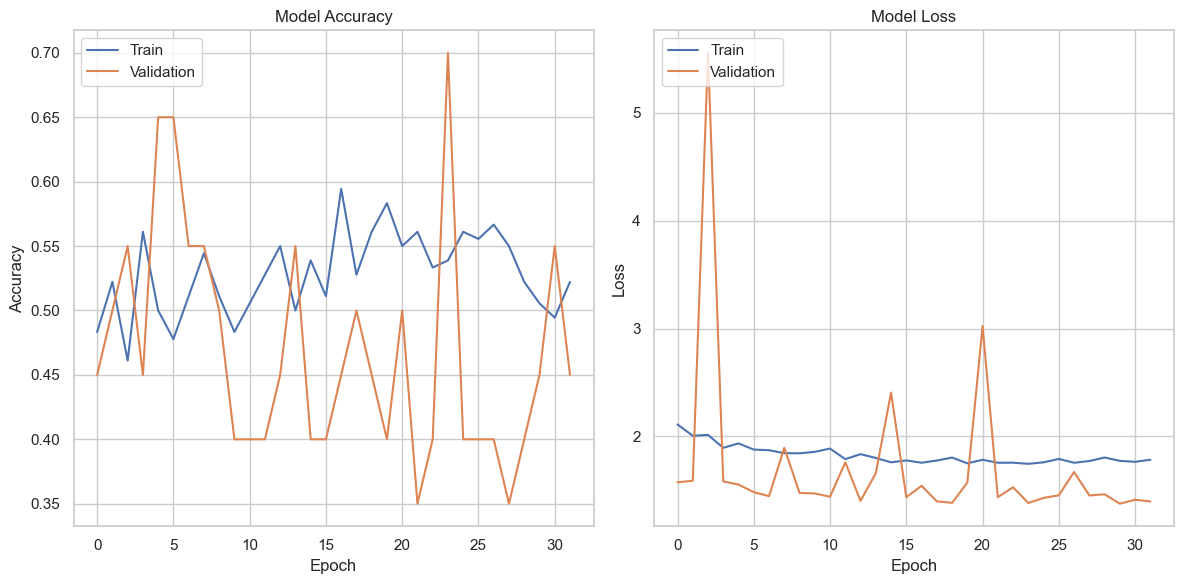

D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000_classifier_ElossPointNet_fold_0_training_history.json
D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000_classifier_ElossPointNet_fold_0_training_history.csv
D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000_classifier_ElossPointNet_fold_0_training_history.npy
7/7 [==============================] - 1s 136ms/step
y_pred [[0.46426302 0.5144667 ]
 [0.46456468 0.5159842 ]
 [0.46494573 0.51300144]
 [0.44679648 0.5317768 ]
 [0.46856472 0.51253676]
 [0.45227894 0.52656823]
 [0.5300091  0.48301023]
 [0.4252183  0.5448285 ]
 [0.39390323 0.5791316 ]
 [0.48134404 0.50858194]
 [0.5371776  0.4805094 ]
 [0.49172783 0.45071223]
 [0.44824368 0.52852994]
 [0.45517588 0.52108663]
 [0.49051857 0.49275896]
 [0.49172887 0.44982606]
 [0.41273326 0.5569655 ]
 [0.41234985 0.5598839 ]
 [0.44227588 0.519991  ]
 [0.5240586  0.50

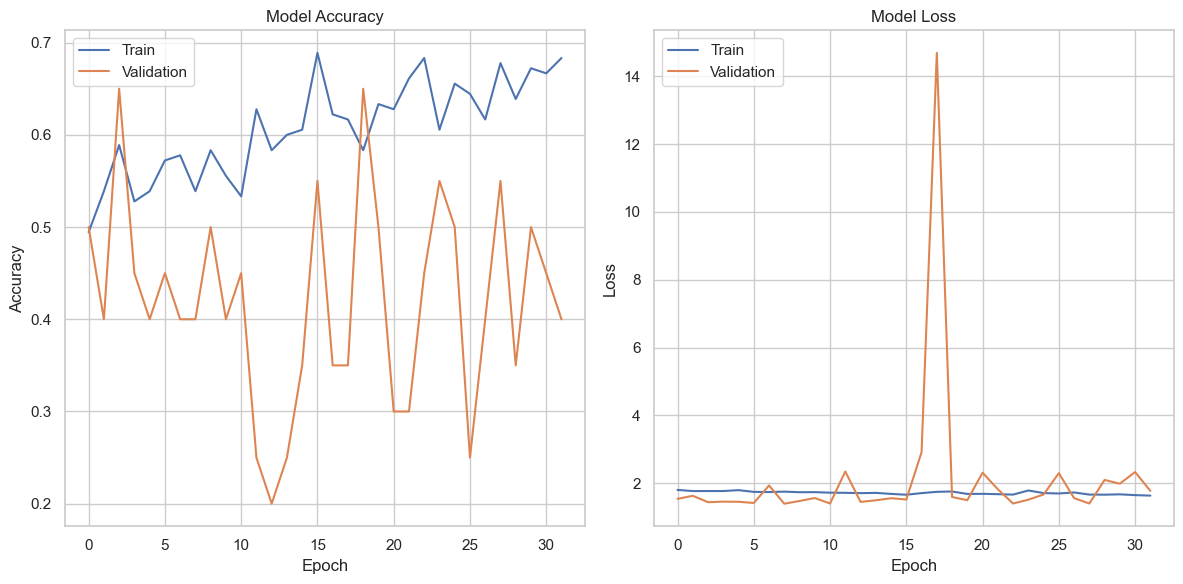

D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000_classifier_ElossPointNet_fold_1_training_history.json
D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000_classifier_ElossPointNet_fold_1_training_history.csv
D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000_classifier_ElossPointNet_fold_1_training_history.npy
7/7 [==============================] - 1s 140ms/step
y_pred [[0.23173052 0.79664034]
 [0.36622825 0.6347903 ]
 [0.22880463 0.7967306 ]
 [0.18194325 0.8417199 ]
 [0.19657403 0.828353  ]
 [0.18357715 0.84020865]
 [0.6422458  0.32327497]
 [0.23484673 0.7879797 ]
 [0.4556218  0.52831084]
 [0.21731097 0.80665606]
 [0.6198544  0.34528875]
 [0.534087   0.521819  ]
 [0.4754895  0.5176874 ]
 [0.19284514 0.8317977 ]
 [0.60109526 0.46186128]
 [0.5785114  0.46270218]
 [0.3712299  0.63443077]
 [0.6253525  0.35724065]
 [0.9055978  0.0715556 ]
 [0.3995589  0.59

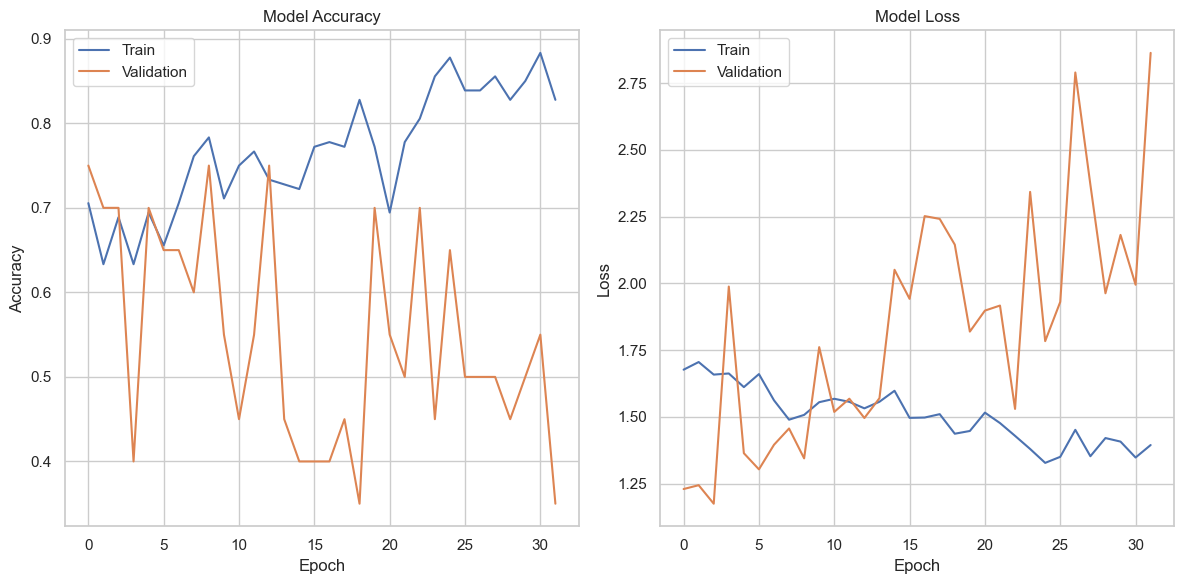

D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000_classifier_ElossPointNet_fold_2_training_history.json
D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000_classifier_ElossPointNet_fold_2_training_history.csv
D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000_classifier_ElossPointNet_fold_2_training_history.npy
7/7 [==============================] - 1s 132ms/step
y_pred [[0.9302281  0.07494583]
 [0.97794646 0.02233656]
 [0.31241083 0.70132583]
 [0.9585255  0.04049726]
 [0.06679291 0.9271537 ]
 [0.9954273  0.00512388]
 [0.9183019  0.08157334]
 [0.27951825 0.7346042 ]
 [0.9958655  0.00474586]
 [0.8597195  0.13512813]
 [0.74642694 0.25868154]
 [0.4871204  0.55066884]
 [0.99652505 0.00410853]
 [0.5868588  0.44398004]
 [0.14113772 0.8300237 ]
 [0.60236216 0.3925762 ]
 [0.04300838 0.9527815 ]
 [0.99524903 0.00538169]
 [0.40953493 0.61227477]
 [0.6304631  0.40

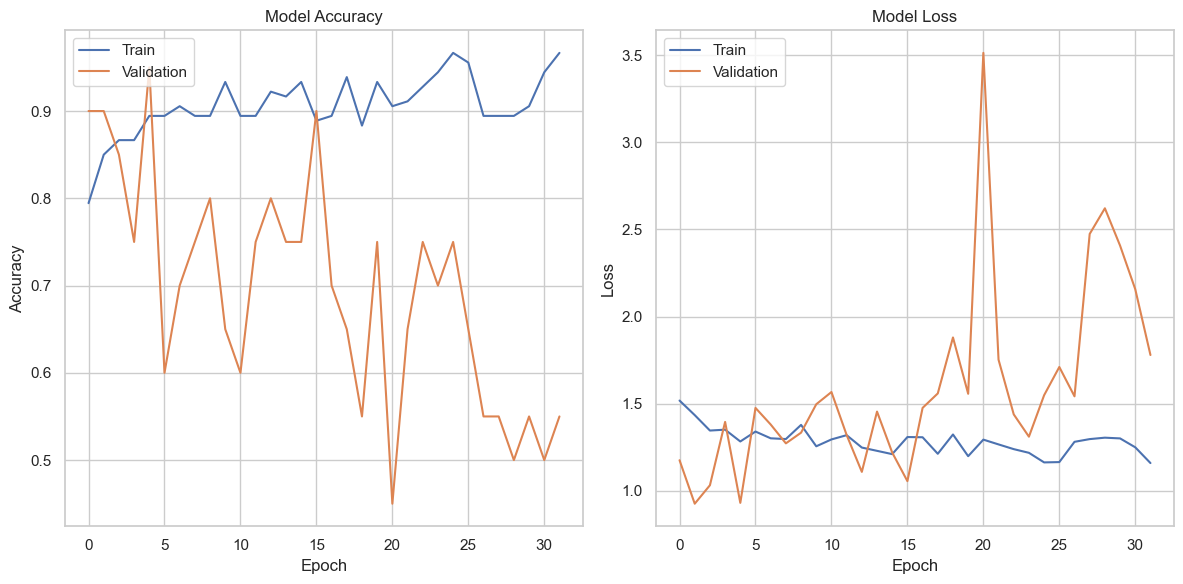

D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000_classifier_ElossPointNet_fold_3_training_history.json
D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000_classifier_ElossPointNet_fold_3_training_history.csv
D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000_classifier_ElossPointNet_fold_3_training_history.npy
7/7 [==============================] - 1s 140ms/step
y_pred [[9.03459191e-01 7.82099664e-02]
 [9.86965597e-01 1.30709996e-02]
 [1.32942759e-02 9.83818531e-01]
 [7.30878294e-01 2.43659005e-01]
 [1.05145082e-01 8.78824651e-01]
 [5.78320920e-01 4.00231242e-01]
 [9.89821434e-01 1.05100218e-02]
 [1.93394497e-01 7.75387168e-01]
 [9.74590003e-01 2.36460604e-02]
 [9.81258631e-01 1.80807021e-02]
 [9.85099494e-01 1.45935528e-02]
 [6.50927305e-01 3.34052324e-01]
 [3.52496296e-01 6.09876752e-01]
 [1.24722376e-01 8.47466707e-01]
 [3.81466597e-01 5.96279740e-0

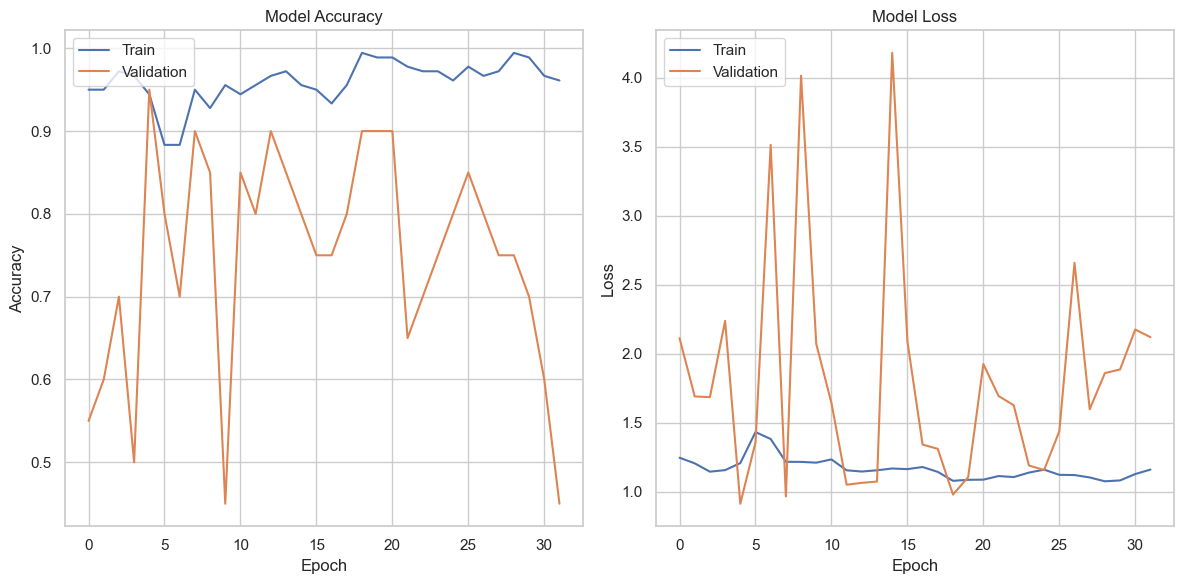

D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000_classifier_ElossPointNet_fold_4_training_history.json
D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000_classifier_ElossPointNet_fold_4_training_history.csv
D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000_classifier_ElossPointNet_fold_4_training_history.npy
7/7 [==============================] - 1s 107ms/step
y_pred [[9.95516062e-01 4.24560672e-03]
 [9.80723202e-01 1.60927009e-02]
 [5.33962727e-01 4.49339986e-01]
 [1.98137271e-03 9.98059630e-01]
 [9.31764208e-03 9.91178453e-01]
 [8.74767196e-04 9.99114096e-01]
 [6.25769913e-01 3.66080076e-01]
 [3.86735708e-01 5.88882506e-01]
 [9.69760120e-01 2.54639294e-02]
 [9.53241408e-01 4.03198376e-02]
 [9.33356941e-01 5.75097799e-02]
 [9.78110313e-01 1.75832994e-02]
 [9.71302867e-01 2.40860414e-02]
 [2.80455733e-03 9.97285187e-01]
 [9.96269822e-01 4.16327594e-0

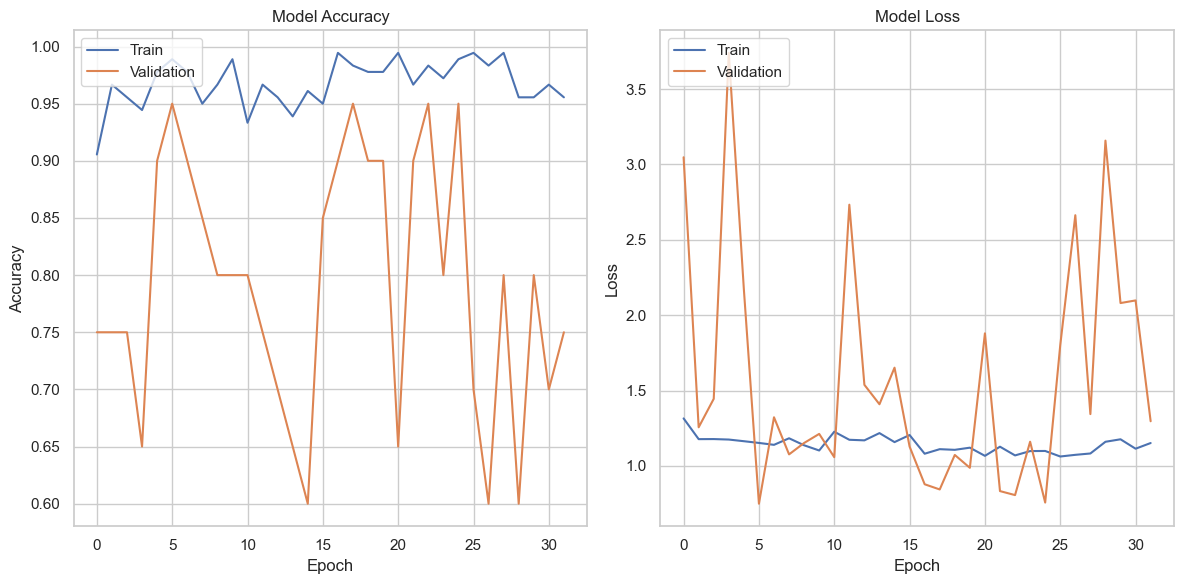

D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000_classifier_ElossPointNet_fold_5_training_history.json
D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000_classifier_ElossPointNet_fold_5_training_history.csv
D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000_classifier_ElossPointNet_fold_5_training_history.npy
7/7 [==============================] - 1s 107ms/step
y_pred [[9.93188500e-01 7.63018429e-03]
 [9.51632857e-01 4.51351814e-02]
 [1.48993090e-03 9.98708010e-01]
 [3.01039801e-03 9.97375667e-01]
 [2.64101988e-03 9.97687817e-01]
 [4.25783638e-03 9.96292055e-01]
 [9.87584710e-01 1.31594595e-02]
 [3.48118250e-04 9.99704897e-01]
 [7.26293862e-01 2.55322933e-01]
 [9.78690028e-01 2.11751480e-02]
 [9.62511241e-01 3.55404988e-02]
 [2.73390720e-03 9.98526216e-01]
 [6.37622714e-01 3.52991521e-01]
 [2.24750853e-04 9.99810636e-01]
 [1.28289068e-03 9.98899937e-0

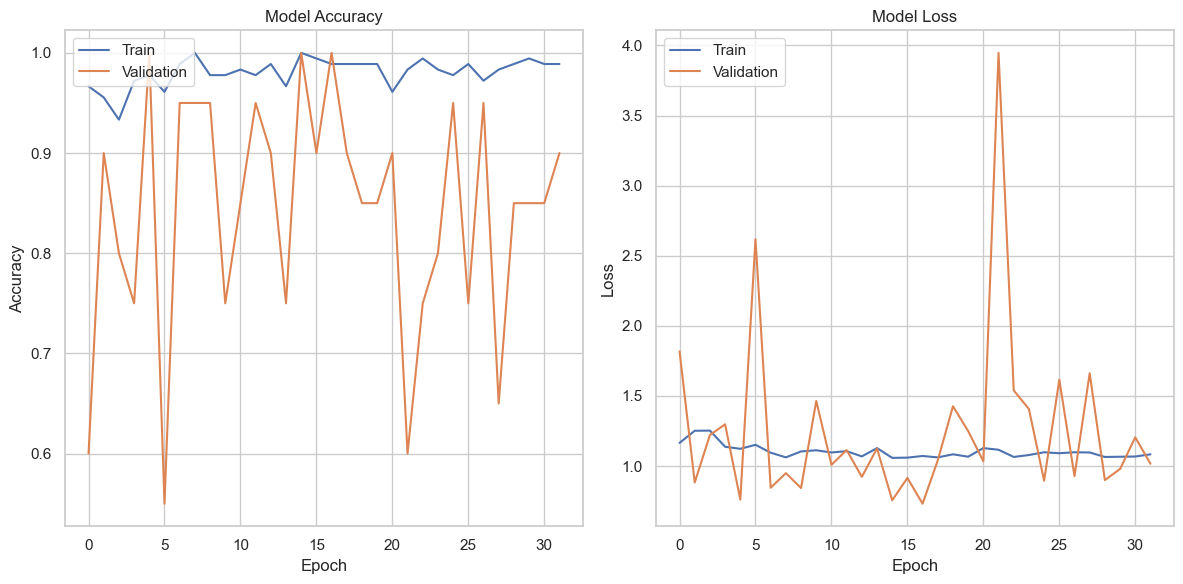

D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000_classifier_ElossPointNet_fold_6_training_history.json
D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000_classifier_ElossPointNet_fold_6_training_history.csv
D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000_classifier_ElossPointNet_fold_6_training_history.npy
7/7 [==============================] - 1s 107ms/step
y_pred [[9.72334325e-01 2.81880051e-02]
 [9.97749567e-01 2.35014409e-03]
 [3.60326911e-03 9.96855199e-01]
 [2.42210156e-03 9.97856855e-01]
 [2.93450765e-02 9.71955121e-01]
 [6.10970485e-04 9.99452412e-01]
 [9.99121845e-01 8.68685544e-04]
 [3.77869146e-04 9.99665797e-01]
 [9.95837569e-01 4.23041265e-03]
 [9.97965455e-01 2.16678856e-03]
 [9.93622959e-01 6.34449022e-03]
 [4.09201311e-05 9.99891043e-01]
 [9.87009764e-01 1.31714605e-02]
 [7.40436837e-04 9.99338865e-01]
 [1.96528807e-03 9.96231079e-0

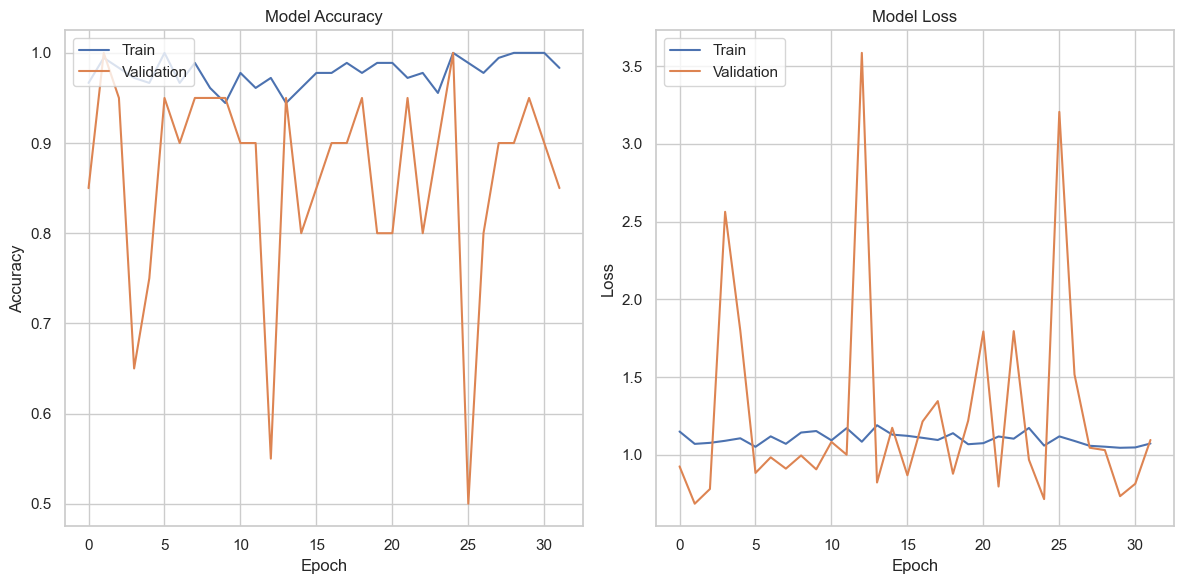

D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000_classifier_ElossPointNet_fold_7_training_history.json
D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000_classifier_ElossPointNet_fold_7_training_history.csv
D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000_classifier_ElossPointNet_fold_7_training_history.npy
7/7 [==============================] - 1s 123ms/step
y_pred [[9.98775184e-01 1.64500705e-03]
 [9.89966094e-01 1.00384839e-02]
 [1.66853158e-06 9.99998569e-01]
 [1.52808410e-04 9.99858797e-01]
 [1.07315289e-04 9.99906957e-01]
 [1.36306307e-05 9.99987662e-01]
 [9.98525620e-01 1.87232299e-03]
 [5.34141072e-05 9.99953747e-01]
 [2.93065067e-02 9.72135484e-01]
 [9.97881711e-01 2.58621131e-03]
 [9.94766951e-01 5.60787646e-03]
 [2.19703023e-03 9.96439457e-01]
 [9.92196083e-01 7.99650047e-03]
 [8.61134777e-06 9.99992311e-01]
 [3.71722854e-04 9.99626875e-0

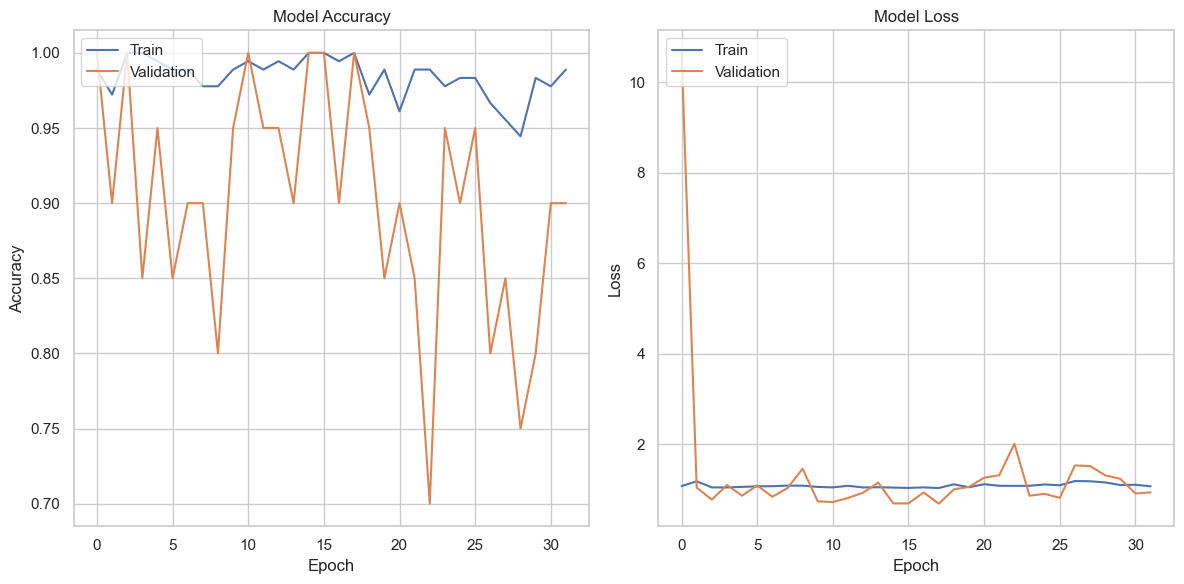

D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000_classifier_ElossPointNet_fold_8_training_history.json
D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000_classifier_ElossPointNet_fold_8_training_history.csv
D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000_classifier_ElossPointNet_fold_8_training_history.npy
7/7 [==============================] - 1s 102ms/step
y_pred [[9.99481618e-01 5.80564374e-04]
 [9.87648606e-01 1.27186067e-02]
 [6.82116952e-04 9.99426603e-01]
 [3.65536143e-05 9.99971986e-01]
 [4.58958326e-03 9.95932162e-01]
 [8.36699153e-04 9.99294937e-01]
 [9.96047497e-01 4.24220506e-03]
 [1.22584452e-05 9.99990880e-01]
 [9.90399420e-01 1.00448411e-02]
 [9.99022961e-01 1.05449709e-03]
 [9.91549373e-01 8.84100981e-03]
 [3.02469516e-06 9.99994934e-01]
 [9.90827143e-01 9.55806300e-03]
 [3.73972034e-05 9.99971330e-01]
 [3.65991364e-05 9.99950707e-0

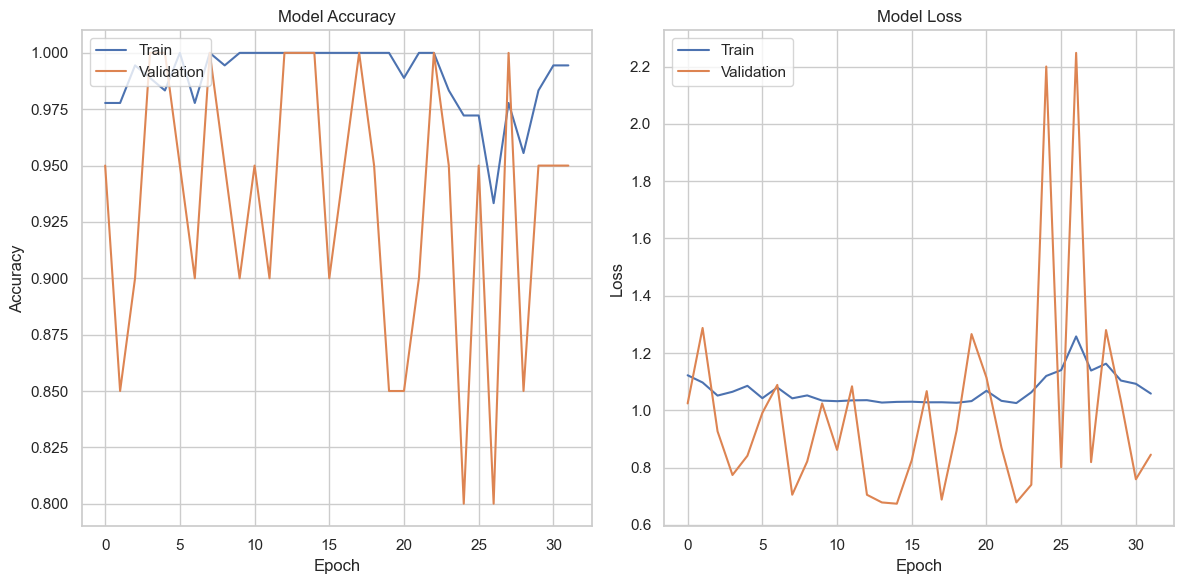

D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000_classifier_ElossPointNet_fold_9_training_history.json
D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000_classifier_ElossPointNet_fold_9_training_history.csv
D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000_classifier_ElossPointNet_fold_9_training_history.npy
7/7 [==============================] - 1s 97ms/step
y_pred [[9.99934256e-01 5.97278922e-05]
 [9.34131920e-01 6.22311980e-02]
 [1.77860820e-05 9.99986649e-01]
 [4.13521557e-05 9.99969125e-01]
 [1.18563525e-01 8.68966639e-01]
 [3.88158835e-04 9.99694288e-01]
 [9.99569654e-01 4.57803369e-04]
 [1.85059653e-05 9.99986529e-01]
 [9.74886119e-01 2.49483418e-02]
 [9.99230623e-01 8.05284420e-04]
 [9.99634743e-01 3.89104098e-04]
 [3.40382690e-06 9.99969602e-01]
 [9.98241842e-01 1.78932946e-03]
 [2.85203326e-02 9.69695807e-01]
 [1.97997112e-02 9.72300410e-01

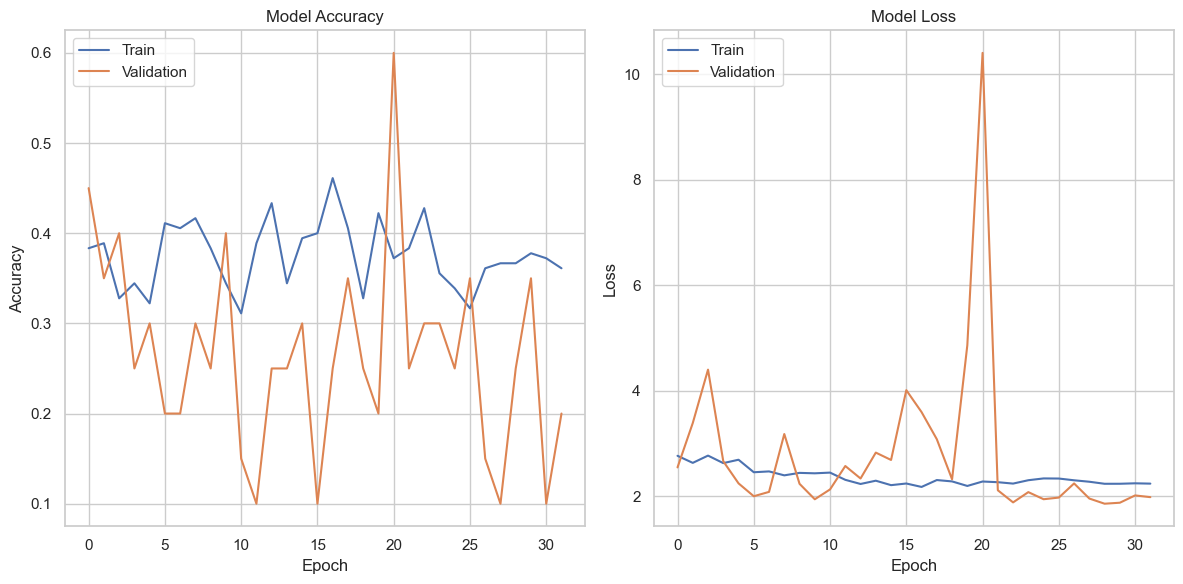

D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000_classifier_AlphaSPointNet_fold_0_training_history.json
D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000_classifier_AlphaSPointNet_fold_0_training_history.csv
D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000_classifier_AlphaSPointNet_fold_0_training_history.npy
7/7 [==============================] - 1s 100ms/step
y_pred [[3.4747779e-01 4.4408202e-01 2.0844018e-01]
 [3.1015465e-01 4.1506475e-01 2.7478063e-01]
 [3.2172194e-01 4.4654617e-01 2.3173191e-01]
 [3.0626163e-01 4.3365654e-01 2.6008183e-01]
 [3.0669579e-01 4.1553691e-01 2.7776727e-01]
 [3.0252051e-01 4.3008938e-01 2.6739007e-01]
 [2.9067263e-01 4.2332500e-01 2.8600237e-01]
 [3.2210910e-01 4.3916759e-01 2.3872326e-01]
 [3.0662850e-01 4.3057016e-01 2.6280135e-01]
 [3.2053137e-01 4.1963723e-01 2.5983137e-01]
 [2.9393423e-01 4.2112726e-01 2.8493851

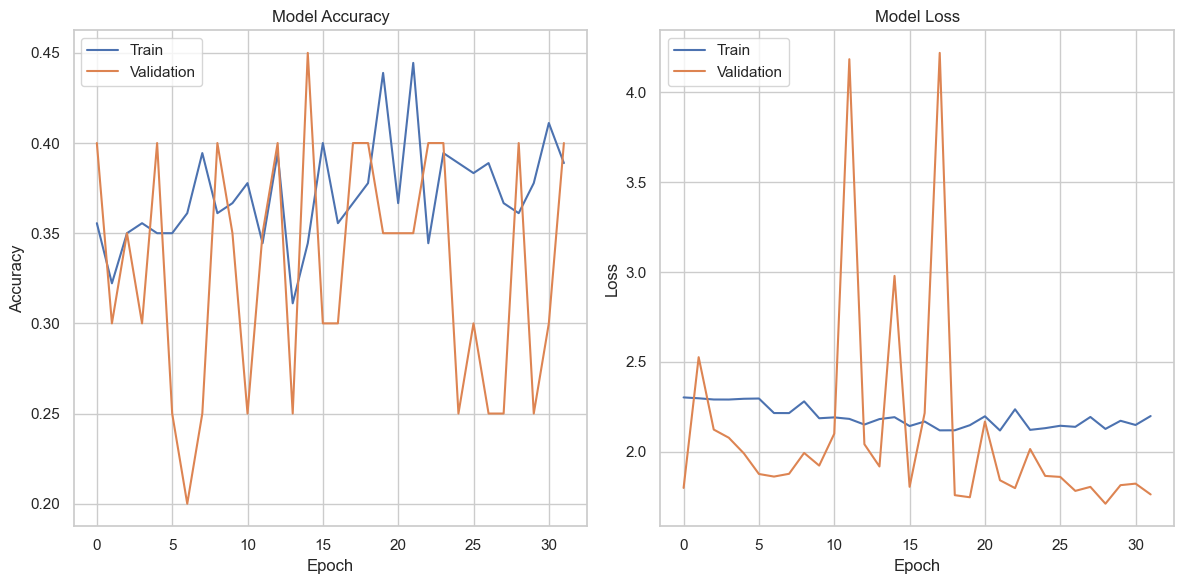

D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000_classifier_AlphaSPointNet_fold_1_training_history.json
D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000_classifier_AlphaSPointNet_fold_1_training_history.csv
D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000_classifier_AlphaSPointNet_fold_1_training_history.npy
7/7 [==============================] - 1s 98ms/step
y_pred [[0.24899775 0.35105777 0.39994445]
 [0.37164873 0.3338553  0.294496  ]
 [0.24553524 0.32997027 0.42449445]
 [0.27504212 0.3344904  0.39046752]
 [0.3665212  0.3342989  0.2991799 ]
 [0.34935024 0.3375933  0.31305644]
 [0.25898007 0.34710962 0.39391038]
 [0.2866802  0.33716697 0.3761528 ]
 [0.28542778 0.3422805  0.3722917 ]
 [0.2994841  0.30457368 0.39594224]
 [0.43983445 0.29611018 0.26405534]
 [0.39156455 0.35319325 0.25524214]
 [0.27841035 0.3382198  0.38336986]
 [0.2485012  0.3284270

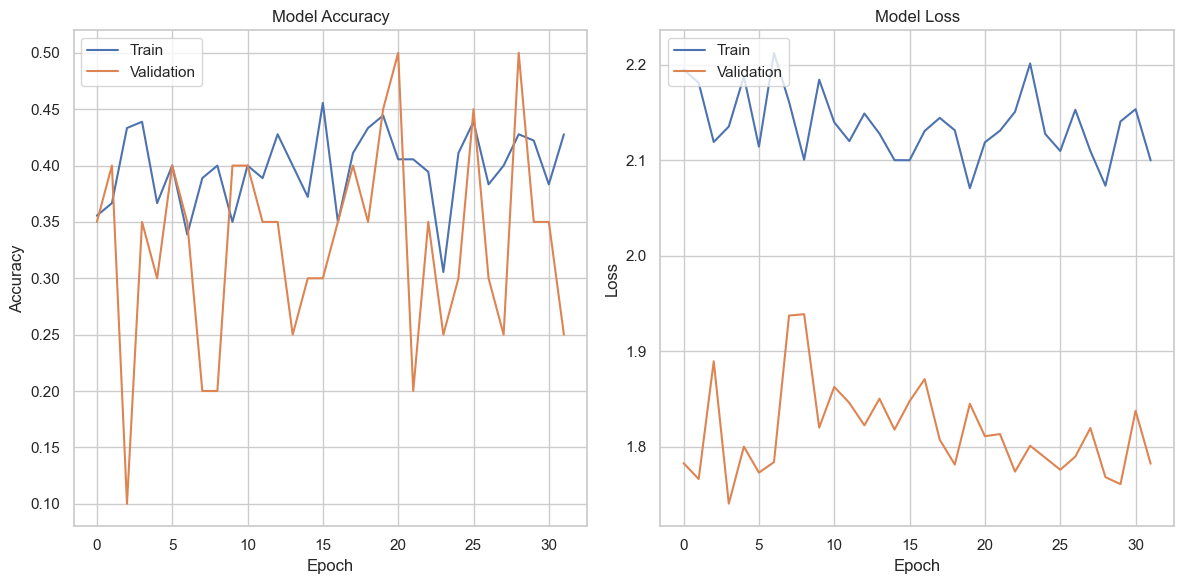

D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000_classifier_AlphaSPointNet_fold_2_training_history.json
D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000_classifier_AlphaSPointNet_fold_2_training_history.csv
D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000_classifier_AlphaSPointNet_fold_2_training_history.npy
7/7 [==============================] - 1s 101ms/step
y_pred [[0.34587    0.3448895  0.30924055]
 [0.39590493 0.39486408 0.20923093]
 [0.35017896 0.3417289  0.3080922 ]
 [0.2832209  0.28377828 0.43300083]
 [0.41796586 0.41163    0.17040418]
 [0.30168965 0.3186168  0.37969357]
 [0.3424917  0.34422478 0.31328353]
 [0.35693148 0.33137593 0.31169266]
 [0.3450061  0.34338835 0.31160554]
 [0.38753742 0.33629903 0.27616352]
 [0.34065357 0.34279218 0.31655425]
 [0.34968674 0.58546764 0.06484566]
 [0.32286263 0.33814907 0.3389883 ]
 [0.31998542 0.317078

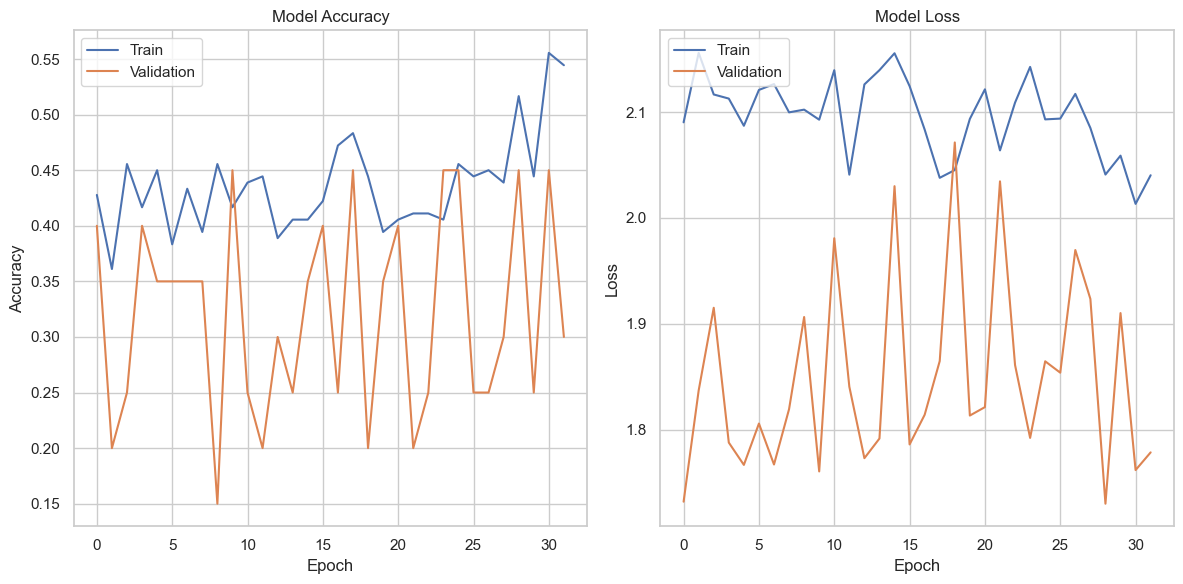

D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000_classifier_AlphaSPointNet_fold_3_training_history.json
D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000_classifier_AlphaSPointNet_fold_3_training_history.csv
D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000_classifier_AlphaSPointNet_fold_3_training_history.npy
7/7 [==============================] - 1s 104ms/step
y_pred [[2.76280850e-01 4.09137726e-01 3.14581424e-01]
 [3.94280821e-01 5.32658100e-01 7.30610043e-02]
 [2.49162480e-01 3.73894662e-01 3.76942873e-01]
 [4.31806207e-01 5.24534464e-01 4.36593704e-02]
 [3.80242854e-01 5.30332744e-01 8.94244090e-02]
 [4.15309548e-01 5.14504731e-01 7.01856613e-02]
 [2.29909614e-01 3.36689383e-01 4.33401048e-01]
 [2.87401259e-01 2.53745943e-01 4.58852828e-01]
 [3.84966969e-01 2.23489001e-01 3.91544044e-01]
 [4.93282944e-01 2.10928828e-01 2.95788258e-01]
 [2.18827

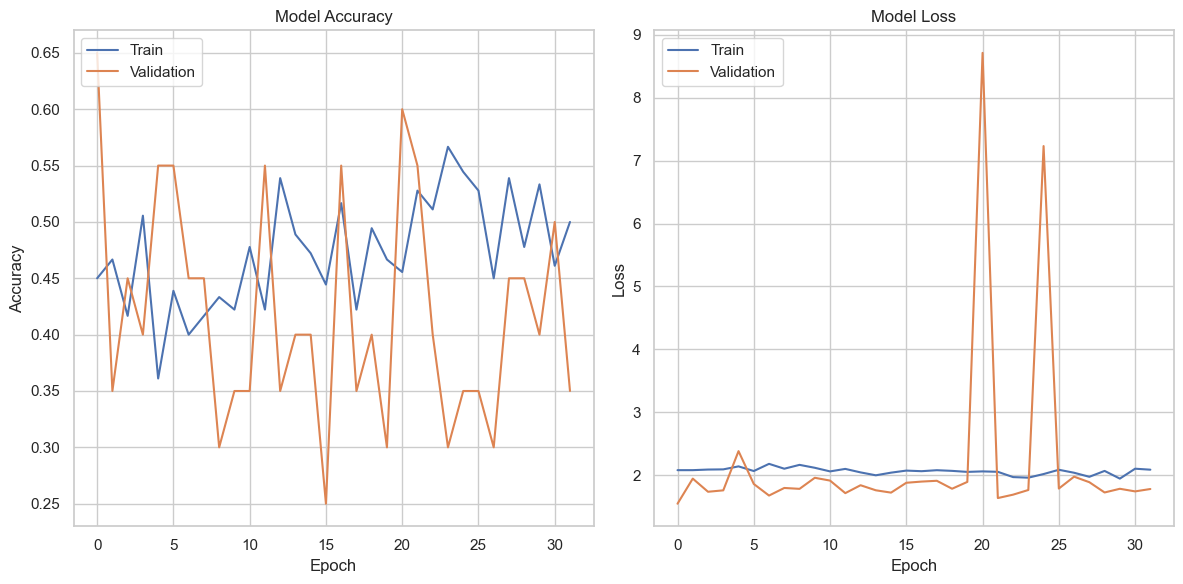

D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000_classifier_AlphaSPointNet_fold_4_training_history.json
D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000_classifier_AlphaSPointNet_fold_4_training_history.csv
D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000_classifier_AlphaSPointNet_fold_4_training_history.npy
7/7 [==============================] - 1s 102ms/step
y_pred [[0.13202702 0.5391009  0.32887214]
 [0.23929088 0.48354617 0.27716294]
 [0.34666792 0.33878532 0.31454673]
 [0.15095495 0.34142813 0.507617  ]
 [0.6988185  0.22045977 0.08072177]
 [0.14402787 0.28328124 0.5726909 ]
 [0.6450554  0.11499882 0.23994578]
 [0.5381569  0.19449757 0.26734555]
 [0.45788634 0.16894895 0.37316474]
 [0.12068097 0.4965736  0.38274533]
 [0.5290142  0.1499902  0.32099554]
 [0.28227383 0.49071294 0.22701326]
 [0.6505356  0.19152947 0.15793501]
 [0.21216844 0.271272

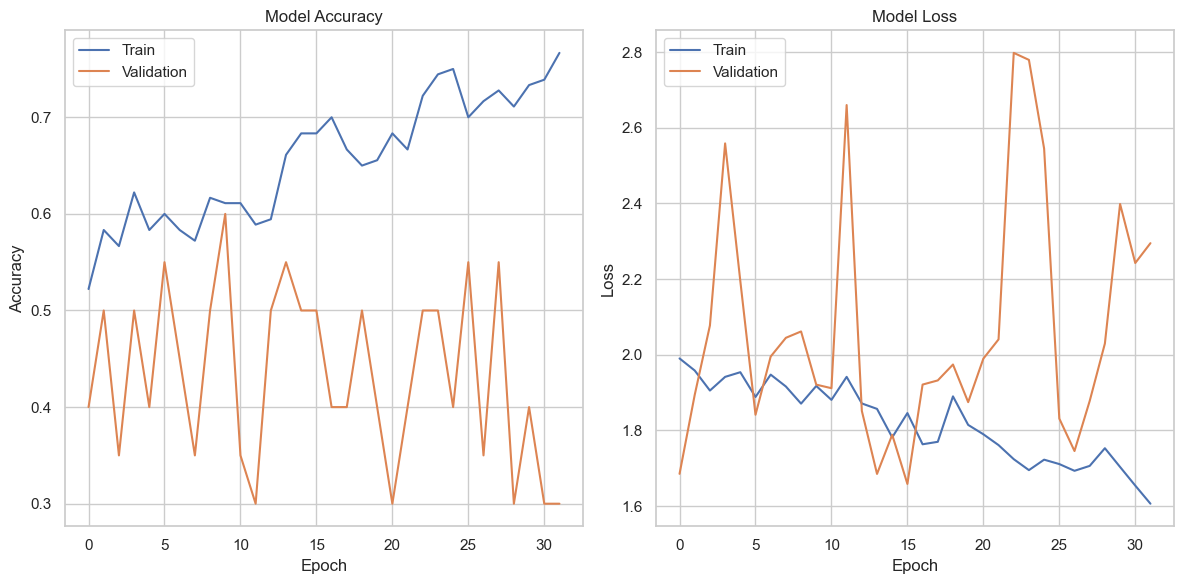

D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000_classifier_AlphaSPointNet_fold_5_training_history.json
D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000_classifier_AlphaSPointNet_fold_5_training_history.csv
D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000_classifier_AlphaSPointNet_fold_5_training_history.npy
7/7 [==============================] - 1s 111ms/step
y_pred [[5.09208024e-01 4.27680582e-01 6.31114915e-02]
 [7.88621426e-01 1.75827995e-01 3.55505645e-02]
 [1.86320588e-01 7.83366621e-01 3.03127971e-02]
 [2.20359623e-01 1.11100949e-01 6.68539464e-01]
 [8.81435752e-01 3.98106165e-02 7.87536353e-02]
 [9.74207222e-01 2.00483035e-02 5.74449683e-03]
 [7.93555081e-01 6.79301322e-02 1.38514802e-01]
 [8.21036398e-01 1.56306818e-01 2.26567127e-02]
 [3.03307563e-01 6.49804771e-01 4.68876213e-02]
 [6.65609360e-01 7.29572102e-02 2.61433512e-01]
 [4.71398

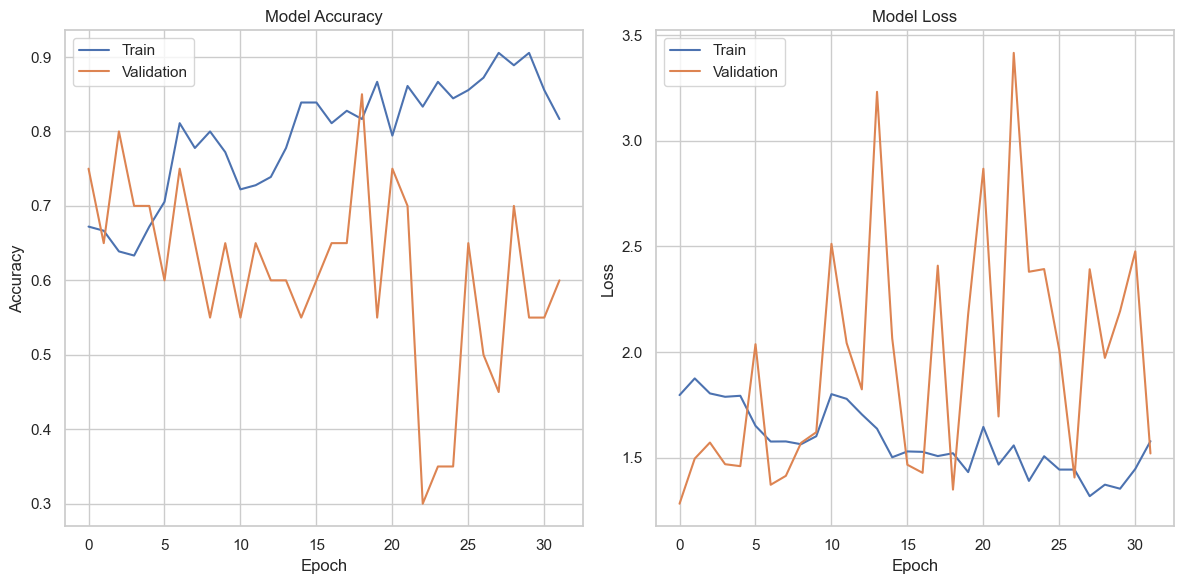

D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000_classifier_AlphaSPointNet_fold_6_training_history.json
D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000_classifier_AlphaSPointNet_fold_6_training_history.csv
D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000_classifier_AlphaSPointNet_fold_6_training_history.npy
7/7 [==============================] - 1s 101ms/step
y_pred [[4.08791844e-03 9.61447001e-01 3.44650336e-02]
 [2.31348583e-03 9.90403175e-01 7.28338677e-03]
 [2.09842771e-02 9.01865184e-01 7.71505386e-02]
 [9.08563752e-03 4.71012667e-02 9.43813086e-01]
 [9.80689228e-01 1.00593520e-02 9.25128441e-03]
 [9.31712866e-01 5.62504083e-02 1.20367734e-02]
 [9.72390115e-01 5.15563926e-03 2.24542841e-02]
 [4.99344291e-03 9.89176571e-01 5.83002297e-03]
 [3.32883629e-03 9.89296973e-01 7.37425499e-03]
 [8.06110539e-03 9.38534081e-01 5.34047931e-02]
 [1.88889

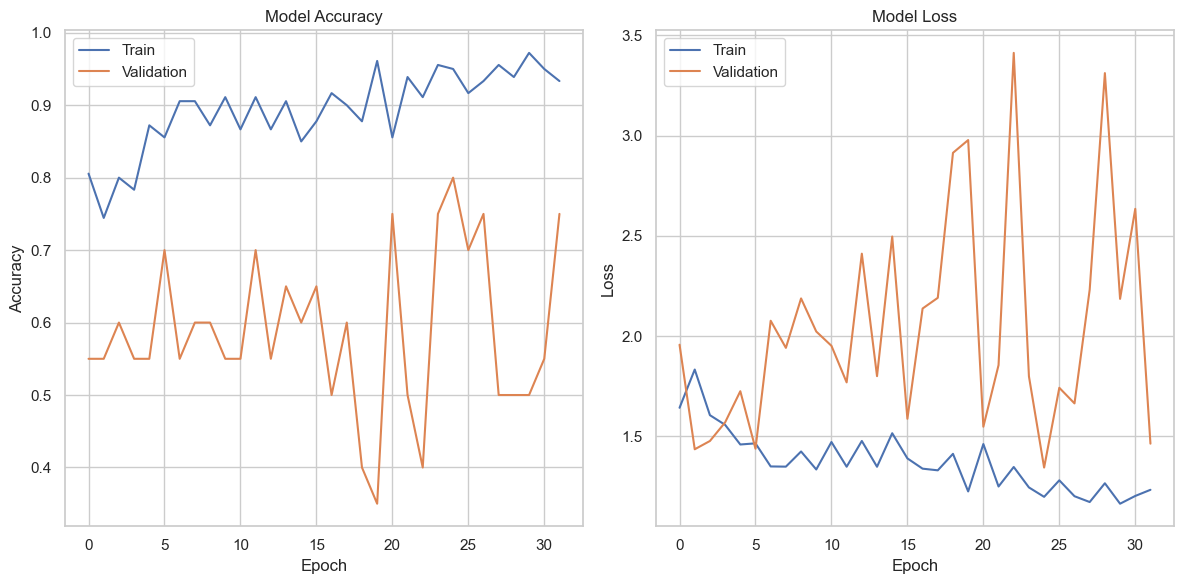

D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000_classifier_AlphaSPointNet_fold_7_training_history.json
D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000_classifier_AlphaSPointNet_fold_7_training_history.csv
D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000_classifier_AlphaSPointNet_fold_7_training_history.npy
7/7 [==============================] - 1s 107ms/step
y_pred [[1.97217576e-02 5.05779982e-01 4.74498242e-01]
 [1.12602231e-03 9.94942725e-01 3.93121643e-03]
 [1.99374417e-03 9.88036394e-01 9.96979140e-03]
 [1.41787843e-03 5.72223030e-03 9.92859781e-01]
 [9.98386621e-01 1.06369960e-03 5.49777527e-04]
 [9.88474965e-01 9.44310520e-03 2.08189012e-03]
 [9.67276394e-01 1.62761305e-02 1.64474752e-02]
 [4.40816991e-02 9.30758834e-01 2.51595490e-02]
 [9.61628929e-03 9.17692900e-01 7.26907775e-02]
 [4.14080312e-03 9.68363404e-01 2.74958108e-02]
 [1.30050

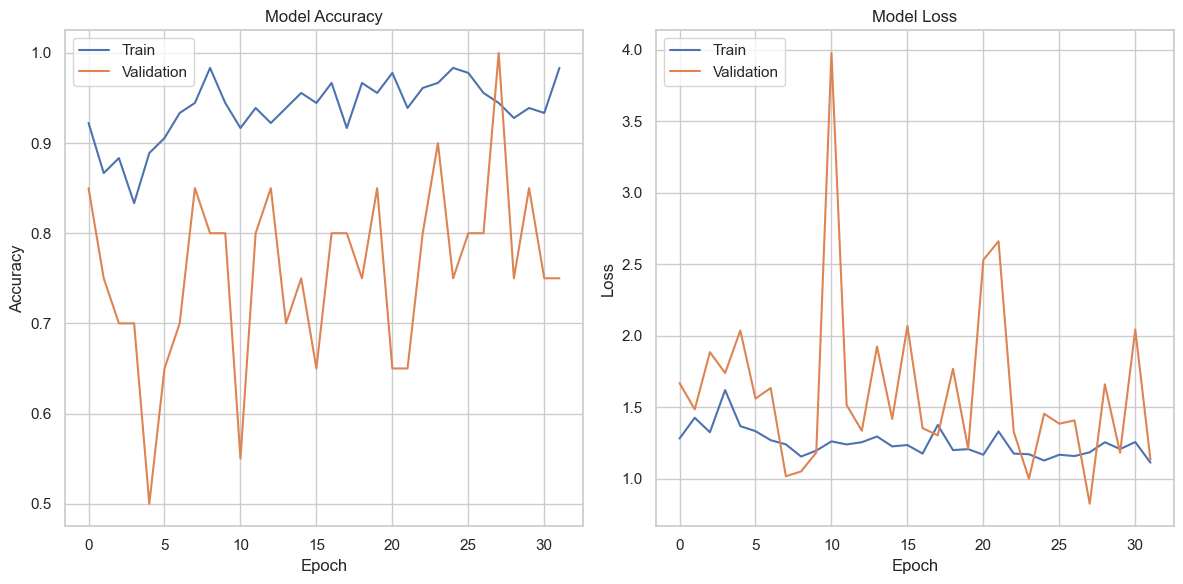

D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000_classifier_AlphaSPointNet_fold_8_training_history.json
D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000_classifier_AlphaSPointNet_fold_8_training_history.csv
D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000_classifier_AlphaSPointNet_fold_8_training_history.npy
7/7 [==============================] - 1s 105ms/step
y_pred [[3.88871483e-03 9.89603400e-01 6.50789496e-03]
 [1.04939155e-02 9.77204323e-01 1.23017849e-02]
 [8.77333432e-03 9.70935047e-01 2.02915743e-02]
 [4.01791856e-02 1.96619090e-02 9.40158963e-01]
 [9.98253524e-01 4.67586273e-04 1.27889204e-03]
 [9.98409748e-01 1.10512762e-03 4.85095254e-04]
 [9.99054134e-01 6.14160148e-04 3.31632735e-04]
 [2.95775896e-03 9.93011057e-01 4.03122744e-03]
 [2.01602317e-02 9.49845910e-01 2.99938358e-02]
 [7.90598243e-03 9.80887532e-01 1.12064788e-02]
 [4.44881

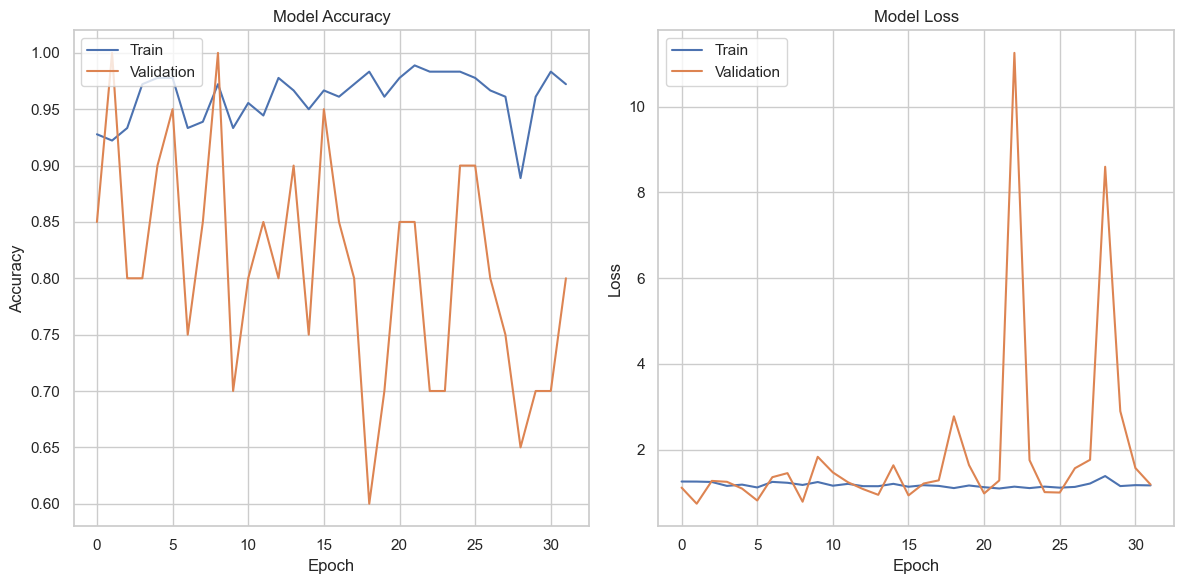

D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000_classifier_AlphaSPointNet_fold_9_training_history.json
D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000_classifier_AlphaSPointNet_fold_9_training_history.csv
D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000_classifier_AlphaSPointNet_fold_9_training_history.npy
7/7 [==============================] - 1s 105ms/step
y_pred [[1.15524349e-03 9.95756447e-01 3.08828265e-03]
 [2.52083819e-02 9.51127291e-01 2.36643571e-02]
 [6.87384186e-03 9.91860211e-01 1.26596959e-03]
 [5.91872726e-04 4.33143956e-04 9.98975039e-01]
 [9.98697340e-01 2.84863956e-04 1.01777003e-03]
 [9.97453511e-01 3.40692874e-04 2.20577582e-03]
 [9.63558495e-01 3.57038230e-02 7.37694267e-04]
 [2.84677977e-03 9.93286431e-01 3.86678590e-03]
 [7.72770308e-03 9.85663772e-01 6.60855882e-03]
 [1.08066911e-03 9.95103478e-01 3.81587842e-03]
 [7.06507

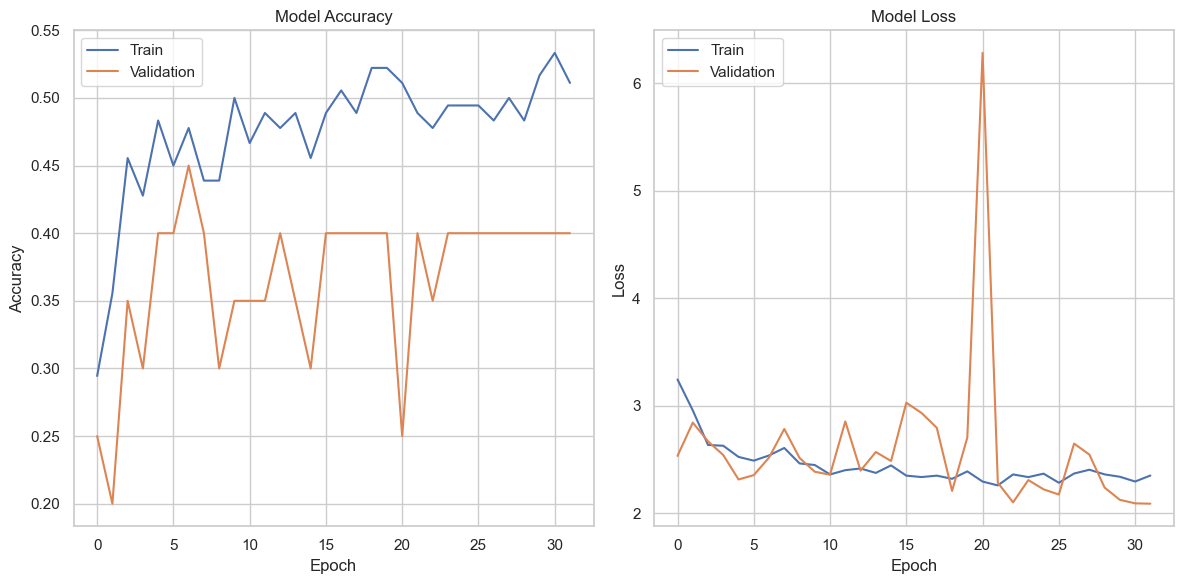

D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000_classifier_Q0PointNet_fold_0_training_history.json
D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000_classifier_Q0PointNet_fold_0_training_history.csv
D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000_classifier_Q0PointNet_fold_0_training_history.npy
7/7 [==============================] - 1s 103ms/step
y_pred [[0.49560574 0.275284   0.09565601 0.1334542 ]
 [0.5566077  0.21621595 0.12515199 0.10202425]
 [0.4939509  0.26048768 0.09382252 0.1517389 ]
 [0.56664693 0.1991077  0.13203357 0.10221182]
 [0.54531294 0.22337997 0.12731828 0.10398883]
 [0.55991524 0.21397586 0.12677027 0.09933862]
 [0.3775856  0.08158065 0.15718742 0.38364628]
 [0.4998328  0.26496348 0.09020783 0.14499596]
 [0.5128239  0.15155284 0.10860001 0.22702327]
 [0.5372961  0.17549251 0.10806979 0.1791415 ]
 [0.3636101  0.08260752 0.15129

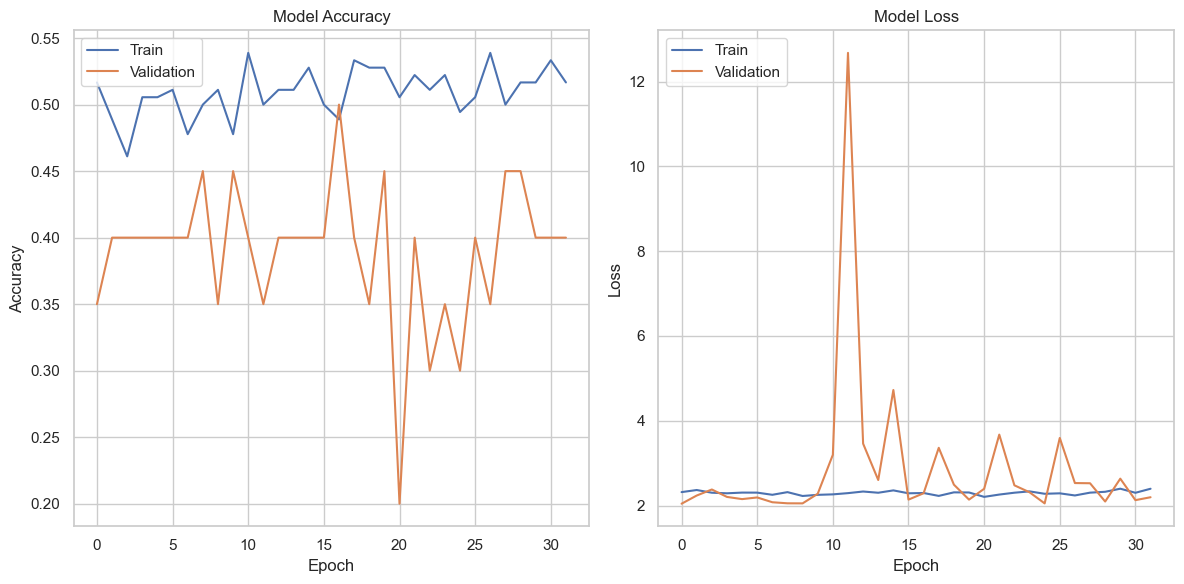

D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000_classifier_Q0PointNet_fold_1_training_history.json
D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000_classifier_Q0PointNet_fold_1_training_history.csv
D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000_classifier_Q0PointNet_fold_1_training_history.npy
7/7 [==============================] - 1s 105ms/step
y_pred [[4.80693996e-01 1.50307775e-01 1.48399234e-01 2.20599040e-01]
 [5.30560732e-01 1.76807925e-01 1.16392210e-01 1.76239133e-01]
 [4.68652725e-01 1.27681628e-01 1.68722168e-01 2.34943509e-01]
 [5.31783462e-01 1.07094951e-01 2.13505998e-01 1.47615597e-01]
 [5.17851174e-01 1.80186674e-01 1.17520534e-01 1.84441581e-01]
 [5.29433727e-01 1.15042239e-01 2.07171306e-01 1.48352727e-01]
 [4.44487303e-01 9.45443809e-02 1.86823234e-01 2.74145126e-01]
 [4.79713440e-01 1.39909789e-01 1.57984570e-01 2.22392157e-0

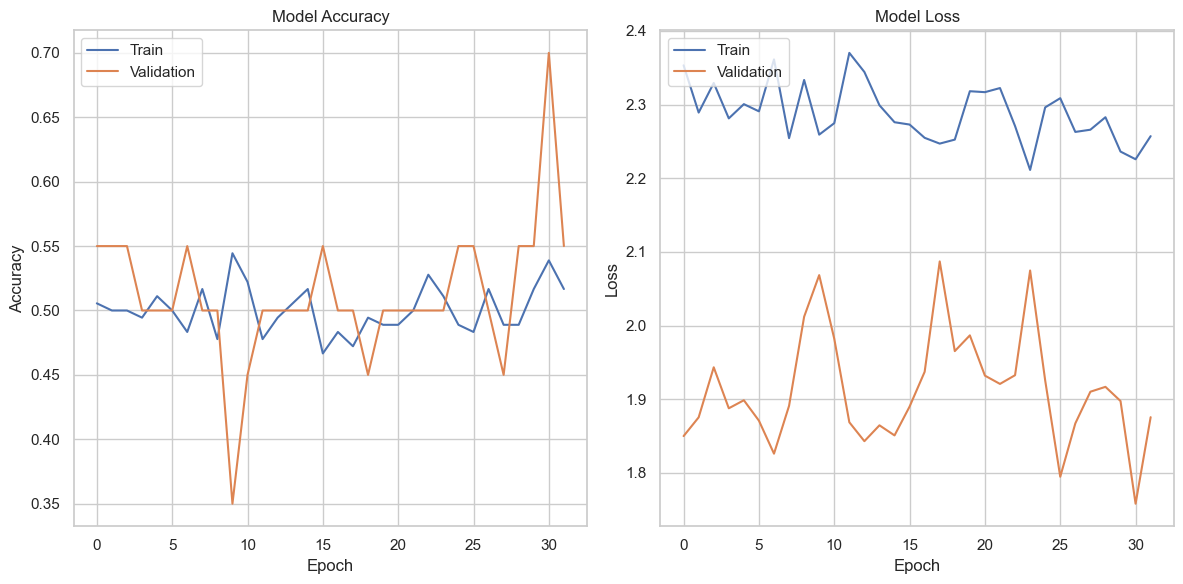

D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000_classifier_Q0PointNet_fold_2_training_history.json
D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000_classifier_Q0PointNet_fold_2_training_history.csv
D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000_classifier_Q0PointNet_fold_2_training_history.npy
7/7 [==============================] - 1s 102ms/step
y_pred [[6.29179835e-01 1.94510669e-01 7.86383078e-02 9.76711661e-02]
 [5.96023440e-01 1.90639645e-01 9.97436866e-02 1.13593251e-01]
 [6.00338221e-01 1.91551700e-01 9.21789706e-02 1.15931176e-01]
 [3.70071501e-01 1.01884089e-01 4.35661316e-01 9.23830569e-02]
 [6.07718229e-01 1.86007380e-01 9.54708904e-02 1.10803522e-01]
 [5.61861813e-01 1.84766054e-01 1.38711691e-01 1.14660487e-01]
 [2.87044793e-01 4.51358706e-02 3.01236838e-01 3.66582423e-01]
 [6.27568603e-01 1.93056315e-01 8.18567201e-02 9.75183323e-0

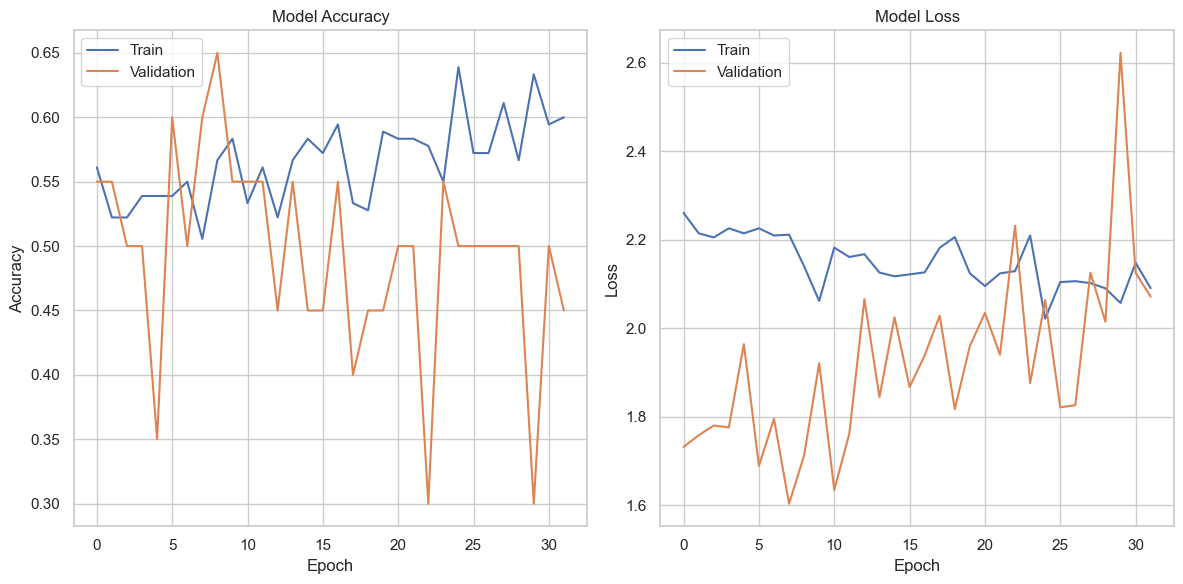

D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000_classifier_Q0PointNet_fold_3_training_history.json
D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000_classifier_Q0PointNet_fold_3_training_history.csv
D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000_classifier_Q0PointNet_fold_3_training_history.npy
7/7 [==============================] - 1s 102ms/step
y_pred [[7.18821883e-01 2.13588536e-01 1.09323449e-02 5.66573031e-02]
 [7.09405601e-01 2.02321947e-01 1.86913181e-02 6.95810989e-02]
 [7.12849677e-01 2.24080369e-01 1.08569572e-02 5.22130057e-02]
 [7.16664493e-01 2.21763492e-01 9.25633591e-03 5.23156859e-02]
 [7.19591379e-01 2.14505389e-01 8.69834516e-03 5.72048463e-02]
 [7.11115122e-01 2.27629125e-01 1.20205302e-02 4.92351912e-02]
 [1.11483842e-01 1.82592999e-02 3.03135306e-01 5.67121625e-01]
 [6.67978823e-01 2.18866333e-01 1.35476608e-02 9.96072143e-0

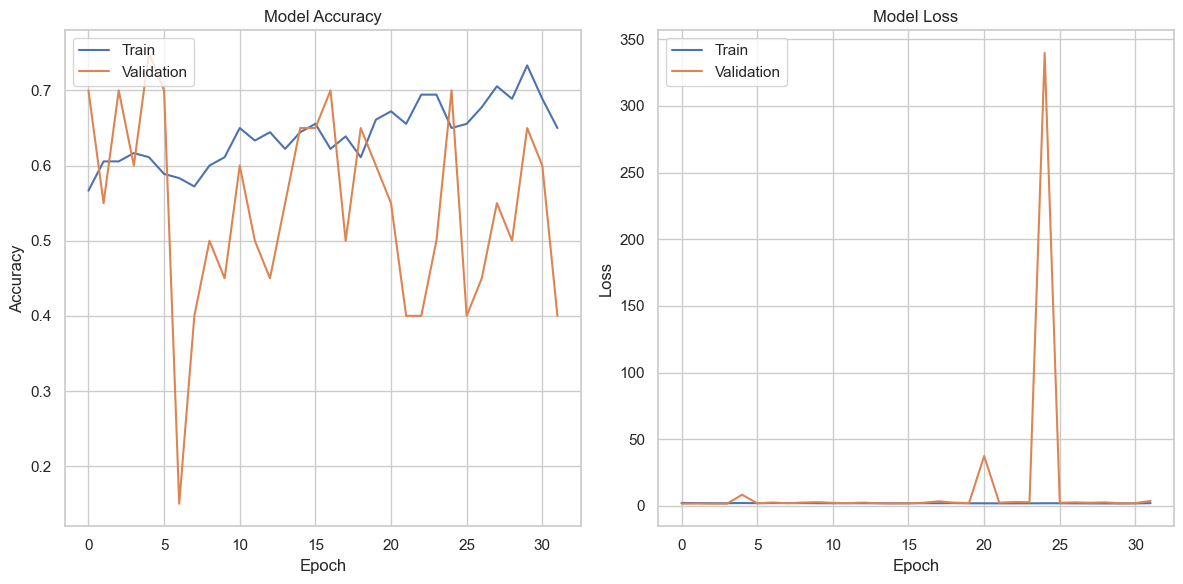

D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000_classifier_Q0PointNet_fold_4_training_history.json
D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000_classifier_Q0PointNet_fold_4_training_history.csv
D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000_classifier_Q0PointNet_fold_4_training_history.npy
7/7 [==============================] - 1s 104ms/step
y_pred [[5.36369264e-01 2.89892644e-01 4.38793190e-02 1.29858807e-01]
 [4.58219759e-02 2.48504877e-02 8.31001043e-01 9.83264819e-02]
 [2.83642203e-01 1.87671781e-01 7.48962164e-02 4.53789771e-01]
 [8.32657397e-01 1.49679020e-01 5.94970956e-03 1.17138959e-02]
 [8.04368794e-01 1.71572208e-01 7.58908177e-03 1.64699219e-02]
 [7.56990612e-01 2.04693496e-01 1.47262998e-02 2.35895421e-02]
 [8.49524915e-01 1.35964632e-01 4.03074082e-03 1.04798125e-02]
 [8.06556761e-01 1.70594037e-01 5.97714679e-03 1.68721061e-0

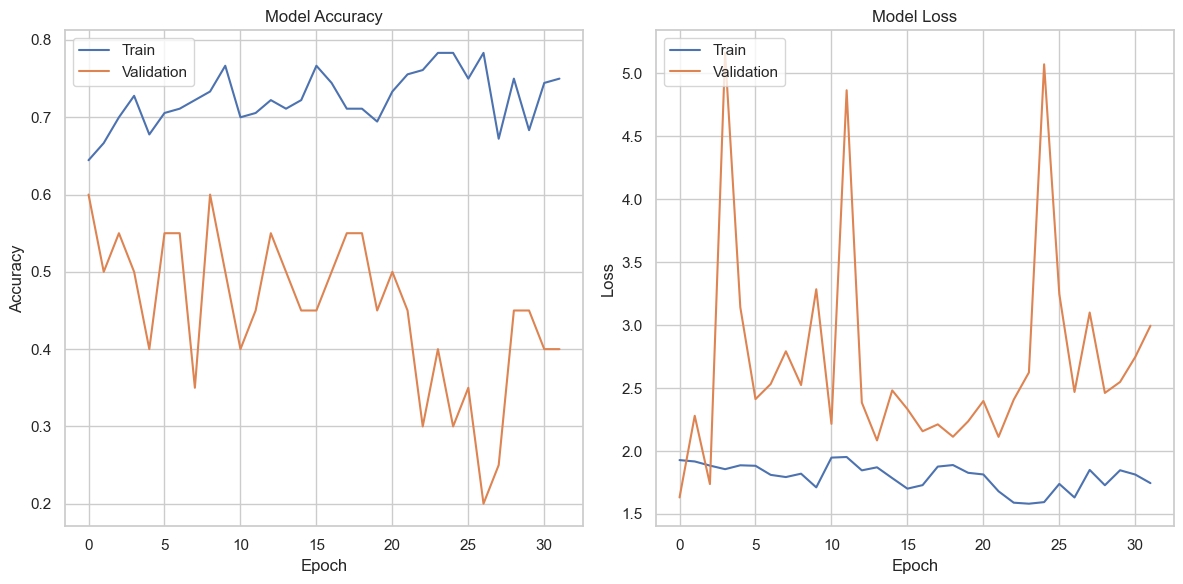

D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000_classifier_Q0PointNet_fold_5_training_history.json
D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000_classifier_Q0PointNet_fold_5_training_history.csv
D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000_classifier_Q0PointNet_fold_5_training_history.npy
7/7 [==============================] - 1s 102ms/step
y_pred [[9.23310290e-04 7.31515349e-04 9.82515335e-01 1.58297960e-02]
 [4.53036465e-03 2.89045228e-03 9.32676673e-01 5.99024557e-02]
 [8.76236796e-01 1.16514504e-01 2.58400524e-03 4.66468232e-03]
 [1.56987131e-01 1.27974629e-01 5.32216668e-01 1.82821542e-01]
 [4.14317399e-01 1.39469013e-01 2.86511511e-01 1.59702122e-01]
 [4.58122902e-02 2.97244769e-02 7.86812365e-01 1.37650907e-01]
 [2.90639132e-01 8.64930525e-02 1.76480576e-01 4.46387172e-01]
 [8.64117920e-01 1.28627390e-01 2.45255674e-03 4.80211759e-0

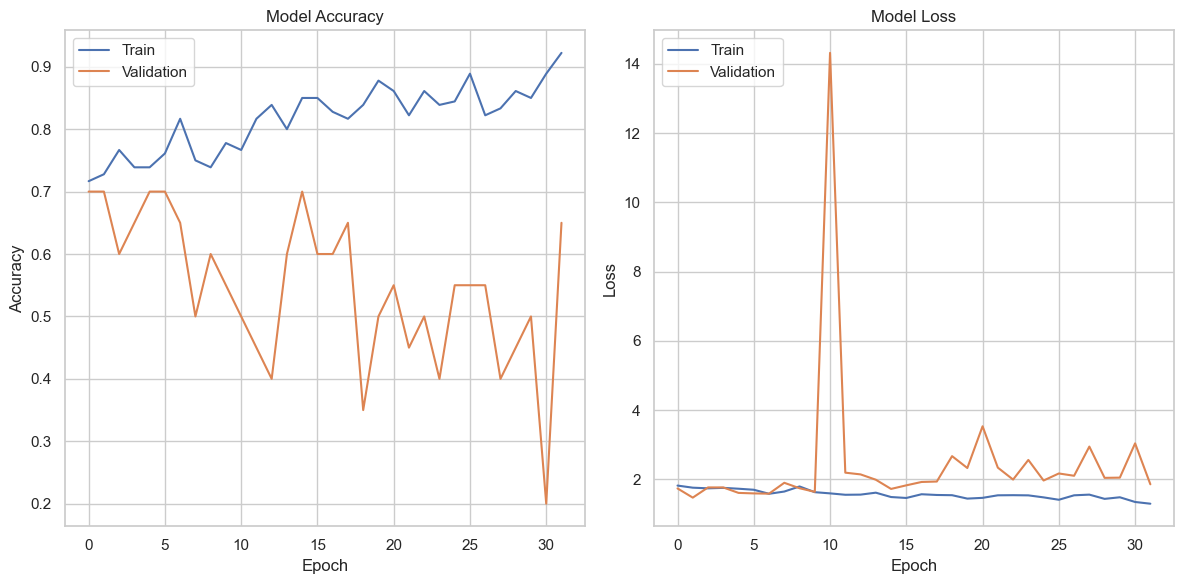

D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000_classifier_Q0PointNet_fold_6_training_history.json
D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000_classifier_Q0PointNet_fold_6_training_history.csv
D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000_classifier_Q0PointNet_fold_6_training_history.npy
7/7 [==============================] - 1s 102ms/step
y_pred [[7.50620365e-02 7.58953333e-01 8.93342029e-03 1.57051191e-01]
 [2.99768131e-02 9.64975238e-01 3.42983025e-04 4.70505795e-03]
 [9.03365135e-01 2.36936938e-02 4.10914831e-02 3.18496935e-02]
 [9.93965328e-01 5.42020425e-03 2.96187354e-04 3.18228500e-04]
 [9.95549202e-01 3.97824869e-03 2.41058151e-04 2.31562182e-04]
 [9.88067925e-01 7.69199524e-03 1.61778287e-03 2.62220623e-03]
 [1.80586390e-02 1.17860427e-02 5.80040319e-03 9.64354932e-01]
 [9.66103017e-01 1.45629775e-02 1.19180148e-02 7.41597079e-0

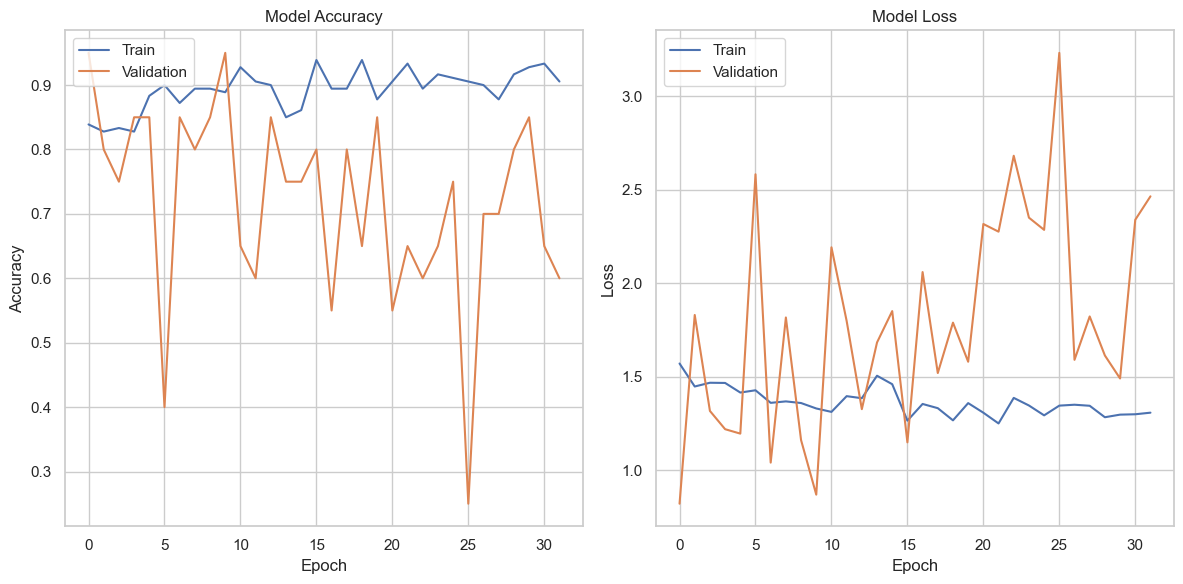

D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000_classifier_Q0PointNet_fold_7_training_history.json
D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000_classifier_Q0PointNet_fold_7_training_history.csv
D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000_classifier_Q0PointNet_fold_7_training_history.npy
7/7 [==============================] - 1s 102ms/step
y_pred [[7.42792338e-02 8.91974211e-01 4.59768996e-03 2.91489009e-02]
 [4.55474481e-02 9.44092035e-01 1.61780242e-03 8.74263421e-03]
 [9.97617543e-01 1.82869507e-03 3.06444970e-04 2.47305288e-04]
 [9.95409191e-01 2.82806810e-03 1.03886856e-03 7.23859004e-04]
 [5.28841376e-01 1.12353452e-02 2.52234638e-02 4.34699744e-01]
 [9.67142344e-01 3.77933239e-03 2.61406600e-02 2.93760095e-03]
 [1.11139135e-03 7.24196667e-04 1.56499213e-04 9.98007953e-01]
 [9.58971262e-01 5.13569871e-03 3.32008675e-02 2.69214064e-0

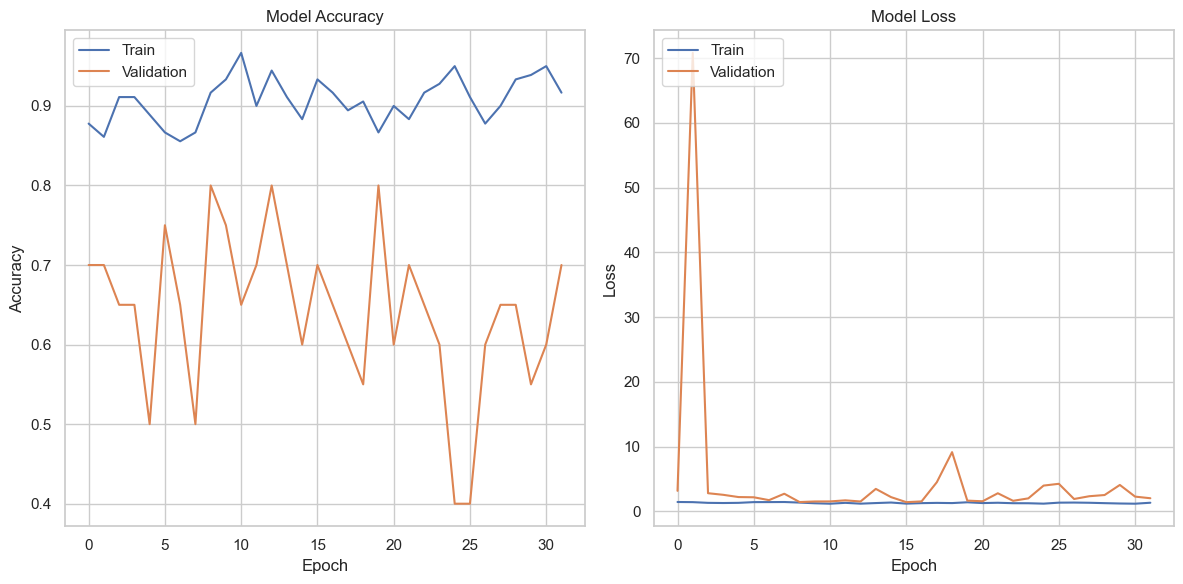

D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000_classifier_Q0PointNet_fold_8_training_history.json
D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000_classifier_Q0PointNet_fold_8_training_history.csv
D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000_classifier_Q0PointNet_fold_8_training_history.npy
7/7 [==============================] - 1s 102ms/step
y_pred [[4.01466377e-02 9.80389416e-02 2.47598570e-02 8.37054610e-01]
 [9.45863187e-01 4.69133295e-02 2.34579295e-03 4.87772888e-03]
 [9.97552812e-01 1.89547834e-03 2.33348357e-04 3.18449136e-04]
 [9.96473491e-01 1.95582816e-03 1.19691866e-03 3.73690214e-04]
 [9.94503617e-01 3.01370467e-03 5.96334052e-04 1.88631658e-03]
 [9.90133405e-01 3.18352645e-03 5.06498851e-03 1.61811861e-03]
 [4.73945998e-02 1.28863323e-02 7.91142974e-03 9.31807697e-01]
 [9.97430384e-01 1.68751774e-03 7.21252232e-04 1.60838899e-0

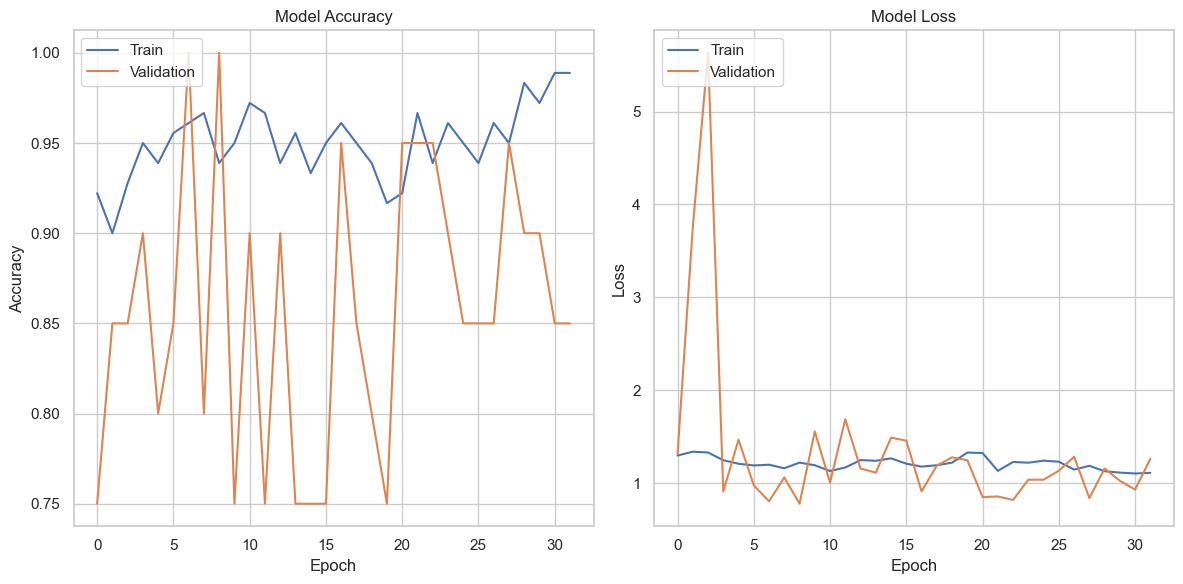

D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000_classifier_Q0PointNet_fold_9_training_history.json
D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000_classifier_Q0PointNet_fold_9_training_history.csv
D:\Projects\110_JetscapeMl\hm.jetscapeml.data\simulation_results\jetml_classification_size_1000_classifier_Q0PointNet_fold_9_training_history.npy
7/7 [==============================] - 1s 105ms/step
y_pred [[1.06534082e-03 9.98683393e-01 6.61019149e-05 1.85179277e-04]
 [2.45841243e-03 1.73302032e-02 6.62852777e-03 9.73582864e-01]
 [9.74800766e-01 1.23732891e-02 6.08550385e-03 6.74041500e-03]
 [7.85486400e-01 1.07112071e-02 1.93858311e-01 9.94415674e-03]
 [9.86049235e-01 1.20764831e-02 1.08413282e-03 7.90106773e-04]
 [9.84121025e-01 7.69562740e-03 3.90607142e-03 4.27735411e-03]
 [3.76667175e-03 1.91113877e-03 5.04930085e-03 9.89272833e-01]
 [9.78578508e-01 1.19191390e-02 3.23741557e-03 6.26492640e-0

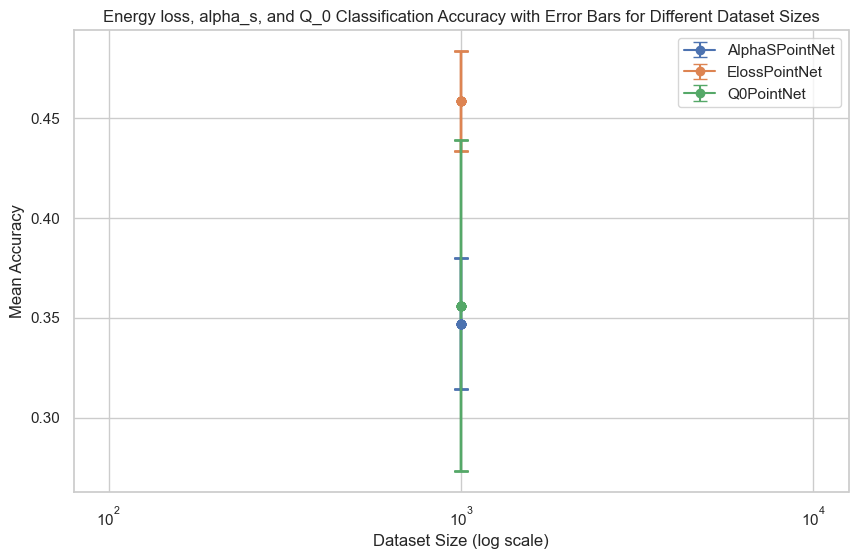

In [34]:
monitor = 'val_accuracy'  # 'val_accuracy' or 'val_loss'
n_epochs = 32
k_folds = 10  # You can adjust the number of folds

# defining dataset sizes and classifiers

# Sizes of datasets
# dataset_sizes = [1000]
dataset_sizes = [10000]
# dataset_sizes = [100000]
# dataset_sizes = [1000000]
# dataset_sizes = [1000, 10000]
# dataset_sizes = [1000, 10000,100000]
# dataset_sizes = [1000, 10000, 100000, 1000000]

print(simulation_directory_path)
# simulation_path=f'{simulation_directory_path}jetml_classification_{class_labels_str}'
simulation_path=f'{simulation_directory_path}jetml_classification'
train_and_evaluate_classifier_for_all_datasets(dataset_sizes,classifiers,simulation_path,n_epochs, monitor, k_folds)